In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

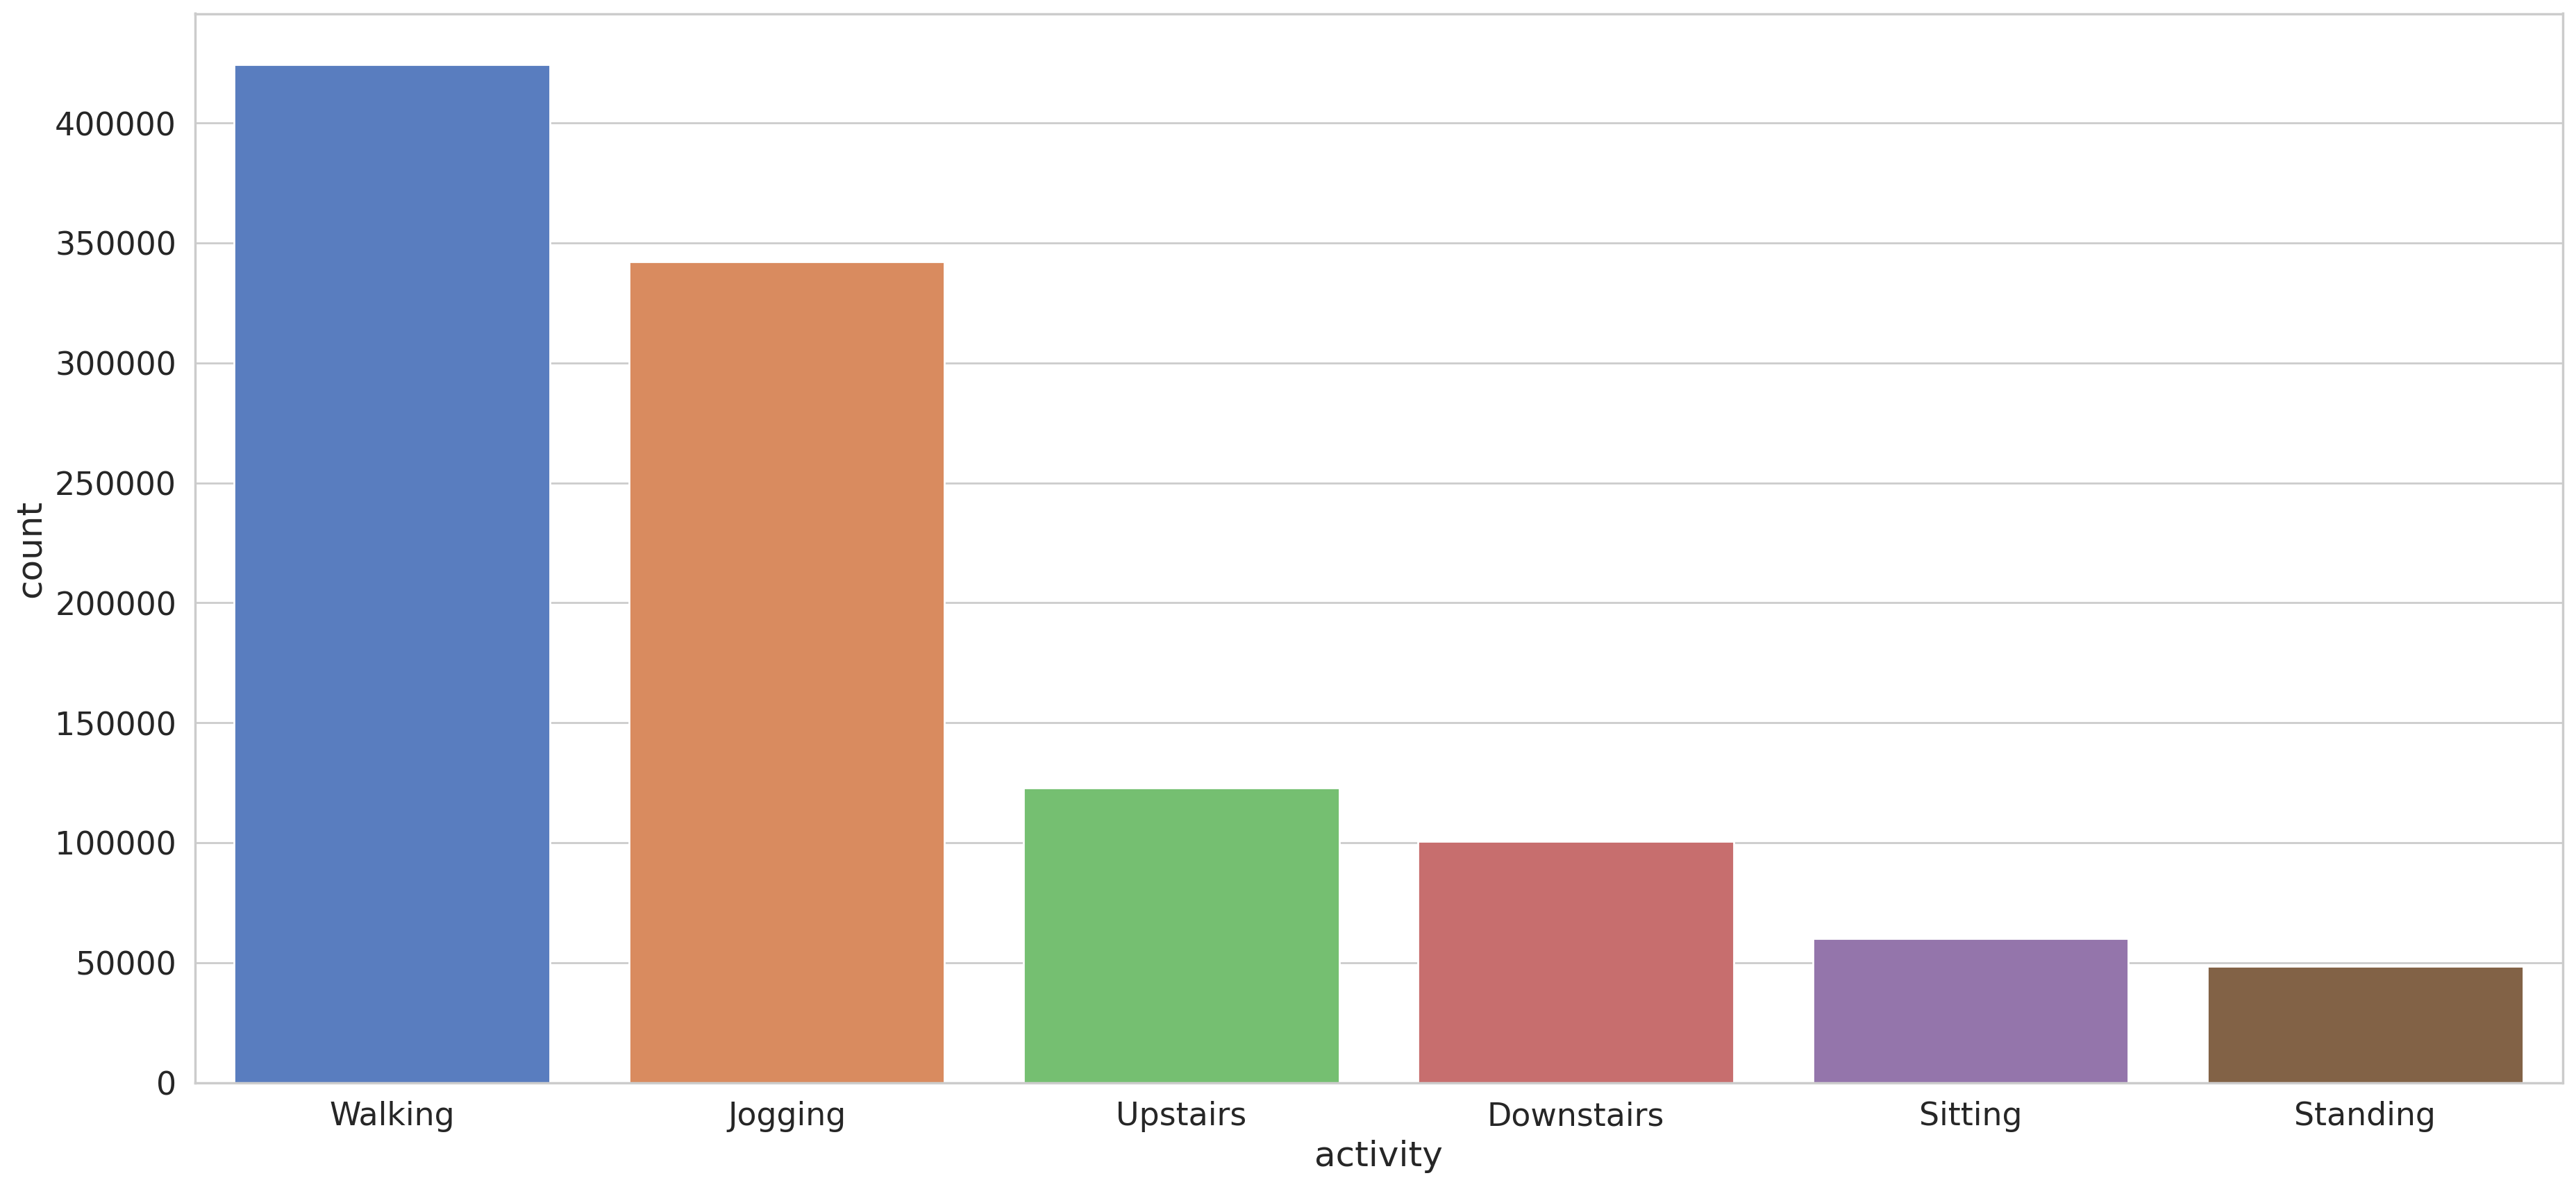

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

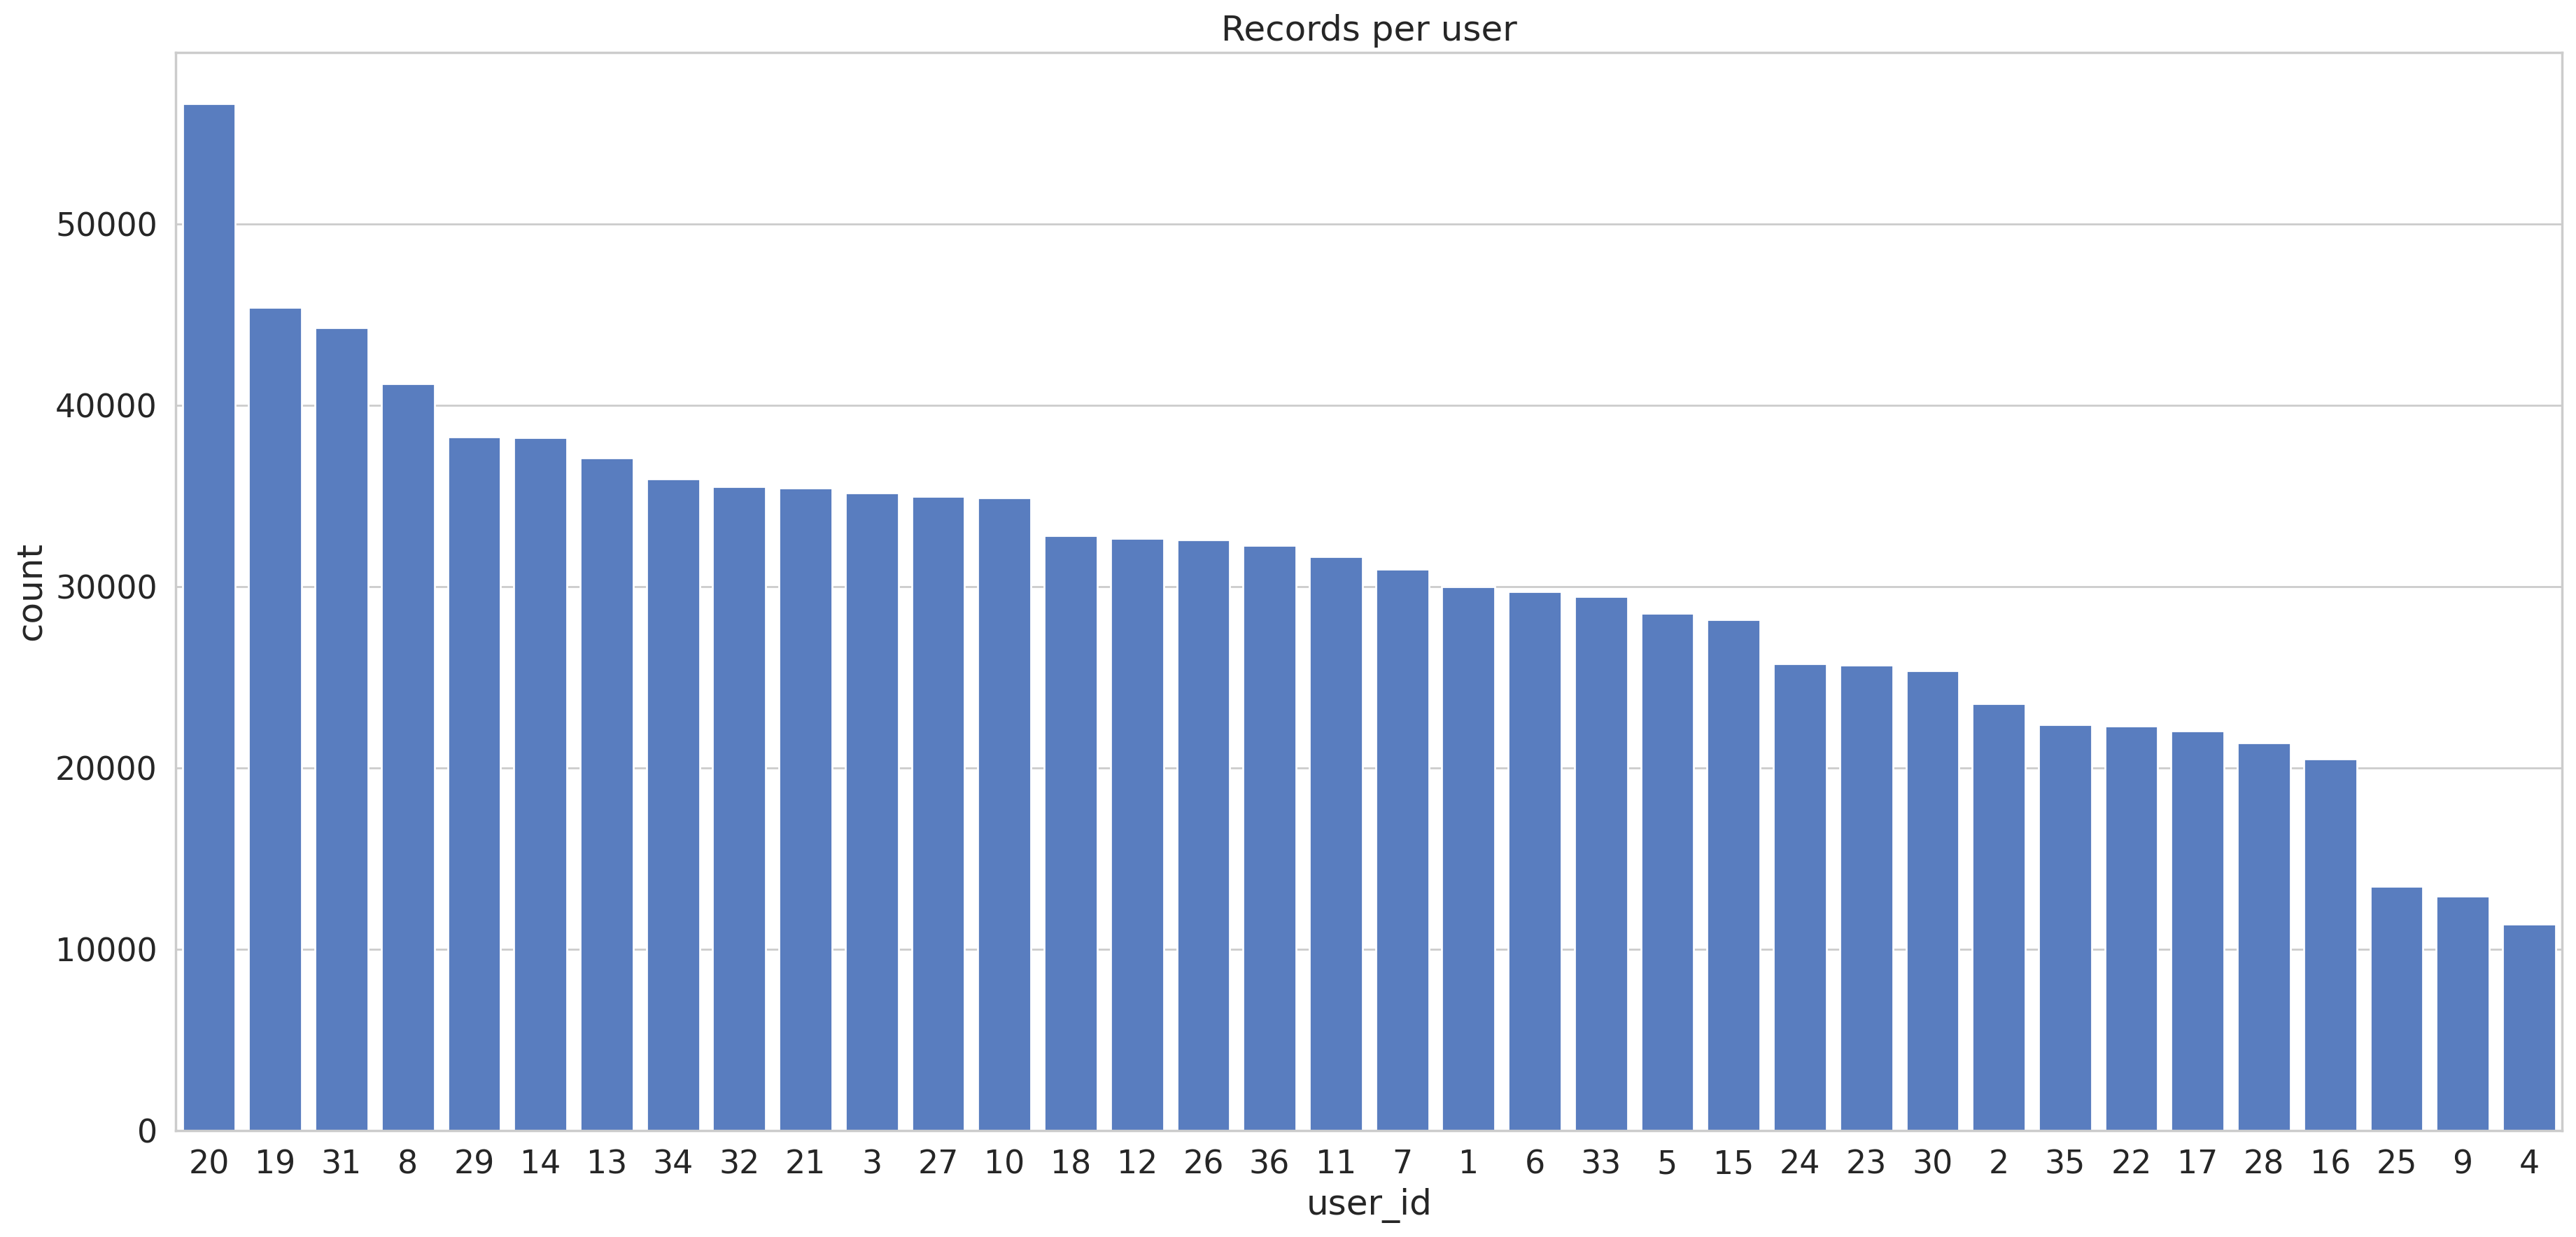

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


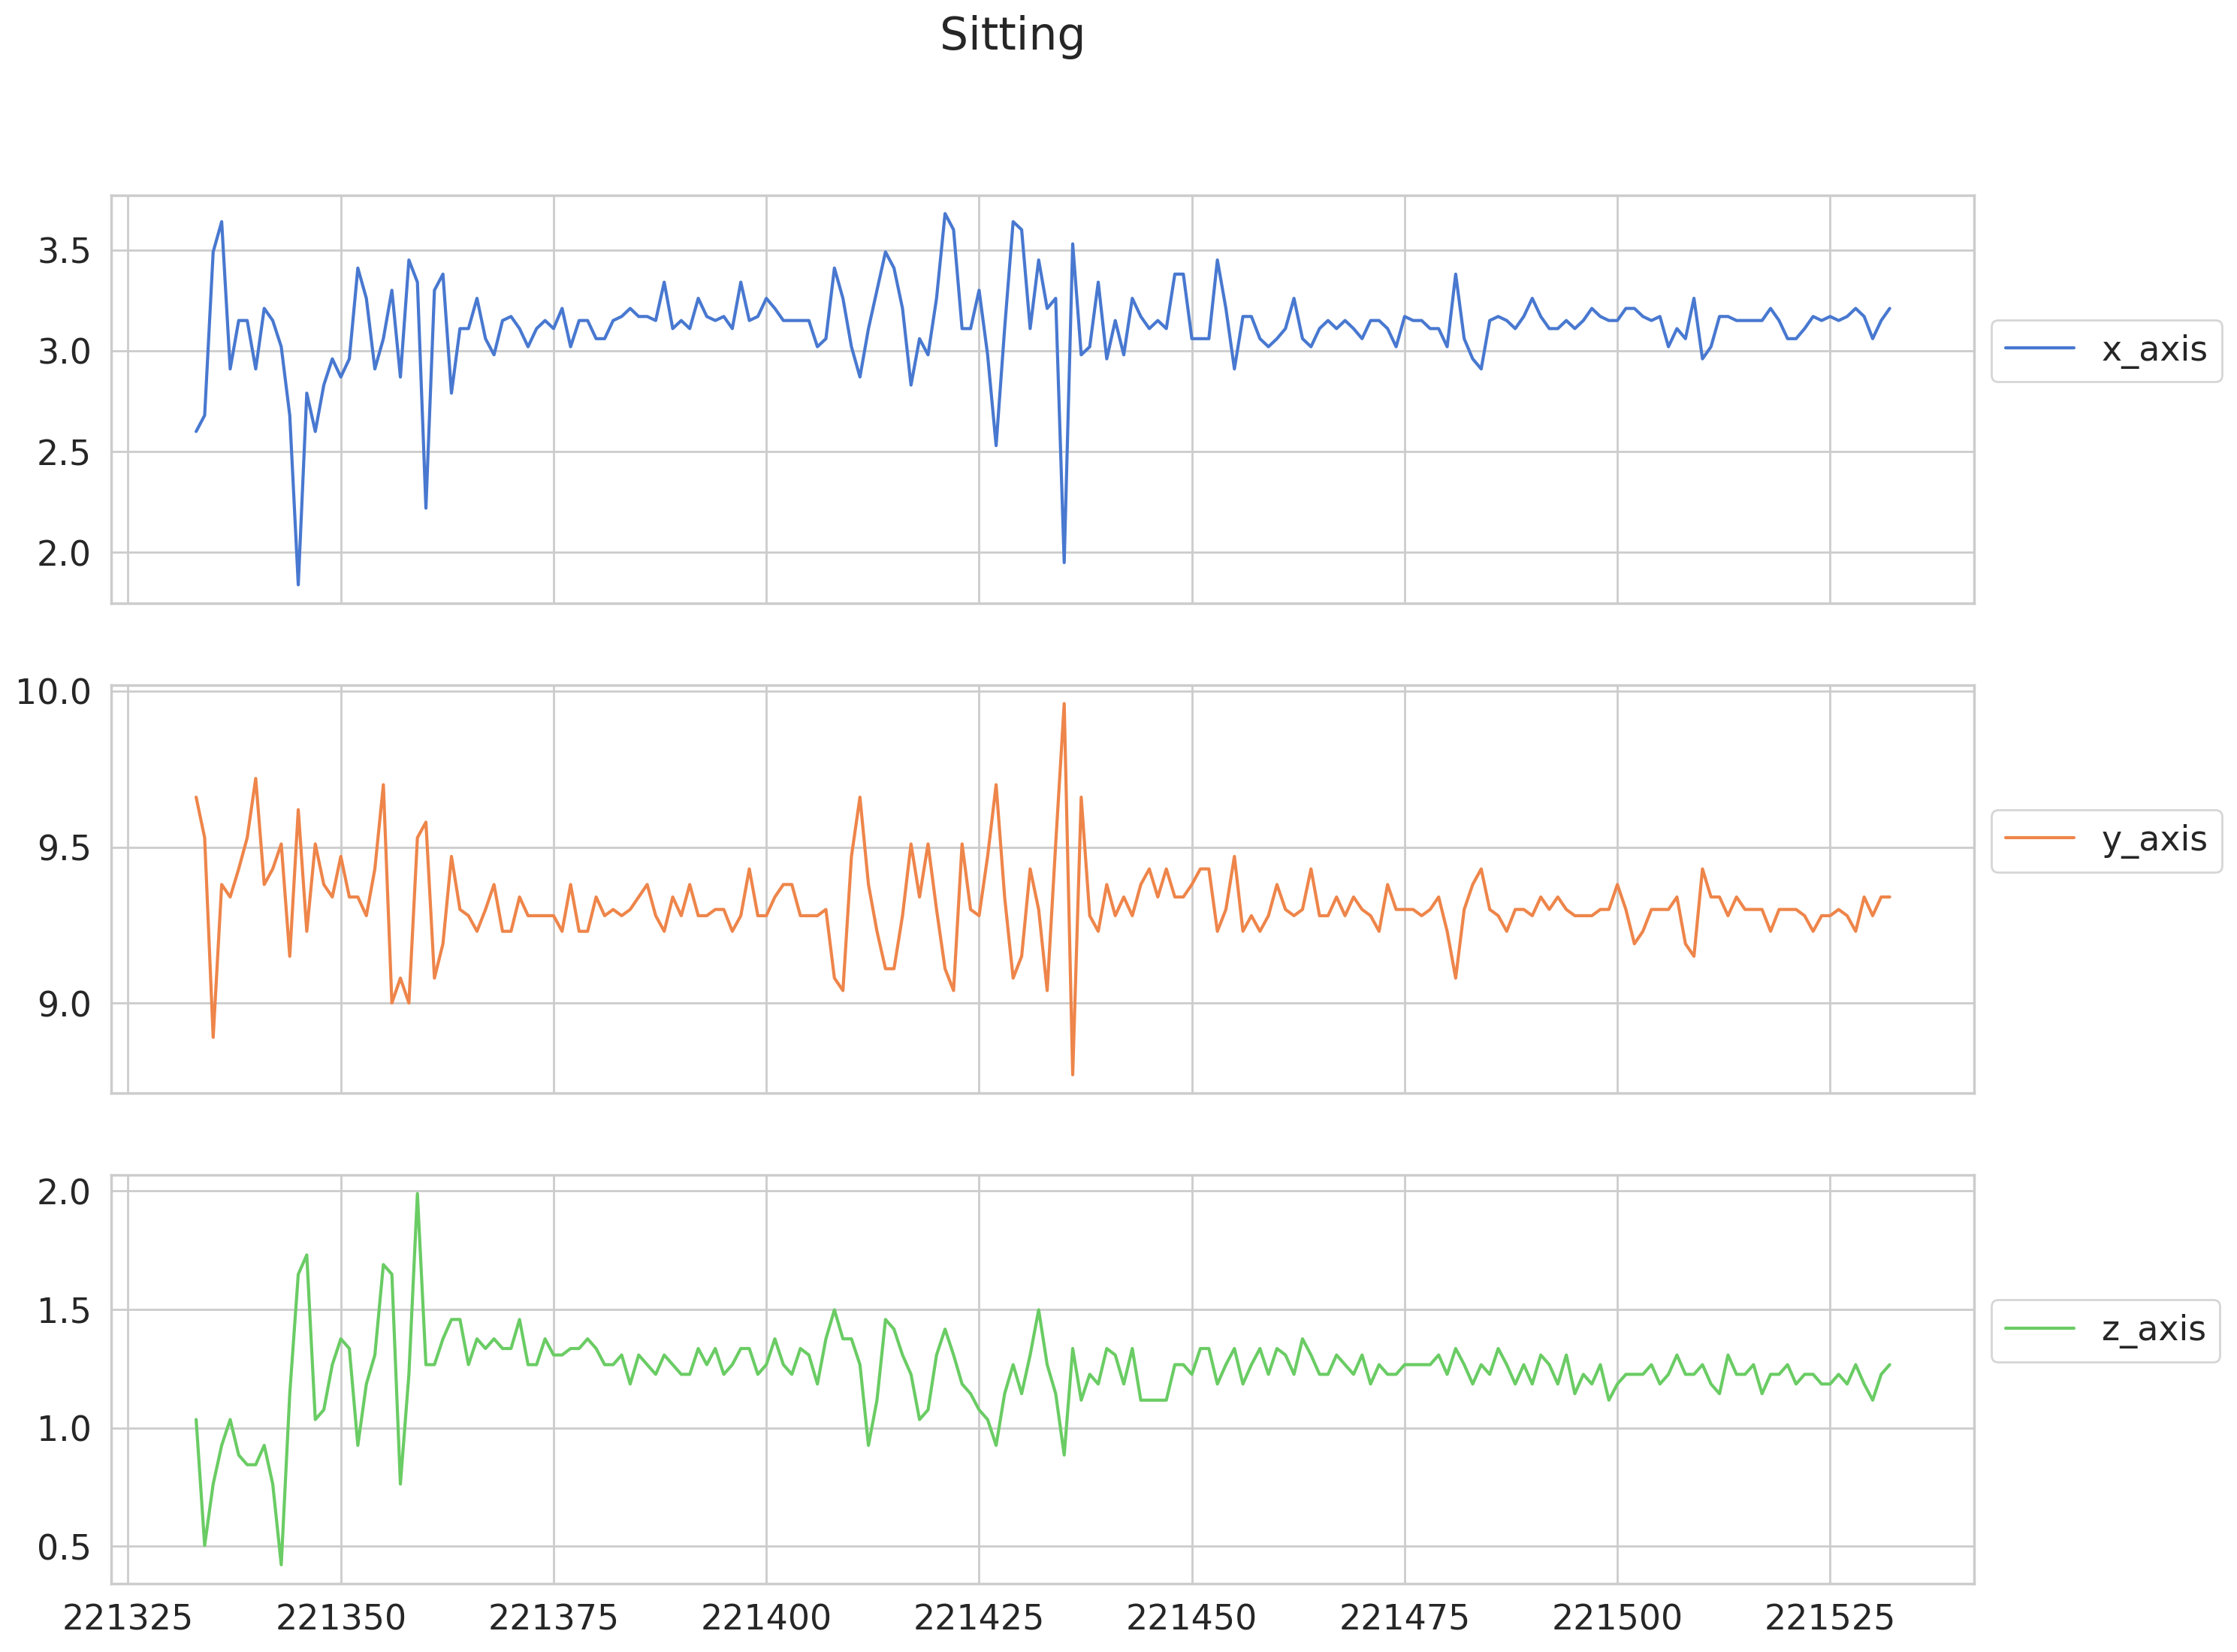

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [9]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.131961  0.566215  0.102015   
1             33  Jogging   49106062271000  0.648740  0.397381  0.193001   
2             33  Jogging   49106112167000  0.633834  0.351926 -0.016543   
3             33  Jogging   49106222305000 -0.120782  1.259408  0.612089   
4             33  Jogging   49106332290000 -0.199038  0.498032  1.458535   
...          ...      ...              ...       ...       ...       ...   
1098200       19  Sitting  131623331483000  1.194254 -1.132300  0.342105   
1098201       19  Sitting  131623371431000  1.199726 -1.119190  0.350202   
1098202       19  Sitting  131623411592000  1.205198 -1.109654  0.342105   
1098203       19  Sitting  131623491487000  1.194254 -1.119190  0.350202   
1098204       19  Sitting  131623531465000  1.177839 -1.103695  0.325911   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

In [10]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70281, 50, 3) (70281, 1)
(21964, 50, 3) (21964, 1)


In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(70281, 50, 3) (70281, 6) (21964, 50, 3) (21964, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 6)

# GRU1


In [13]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               102144    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 118982 (464.77 KB)
Trainable params: 118982 (464.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
69/69 [==============================] - 9s 37ms/step - loss: 1.1617 - accuracy: 0.6129 - val_loss: 0.7627 - val_accuracy: 0.7424
Epoch 2/10
69/69 [==============================] - 2s 27ms/step - loss: 0.6278 - accuracy: 0.7798 - val_loss: 0.5204 - val_accuracy: 0.8133
Epoch 3/10
69/69 [==============================] - 2s 27ms/step - loss: 0.4824 - accuracy: 0.8259 - val_loss: 0.4367 - val_accuracy: 0.8414
Epoch 4/10
69/69 [==============================] - 2s 27ms/step - loss: 0.4227 - accuracy: 0.8444 - val_loss: 0.3803 - val_accuracy: 0.8588
Epoch 5/10
69/69 [==============================] - 2s 29ms/step - loss: 0.3744 - accuracy: 0.8628 - val_loss: 0.3471 - val_accuracy: 0.8721
Epoch 6/10
69/69 [==============================] - 2s 31ms/step - loss: 0.3183 - accuracy: 0.8845 - val_loss: 0.3107 - val_accuracy: 0.8877
Epoch 7/10
69/69 [==============================] - 2s 28ms/step - loss: 0.2687 - accuracy: 0.9053 - val_loss: 0.2421 - val_accuracy: 0.9141
Epoch 8/10
69

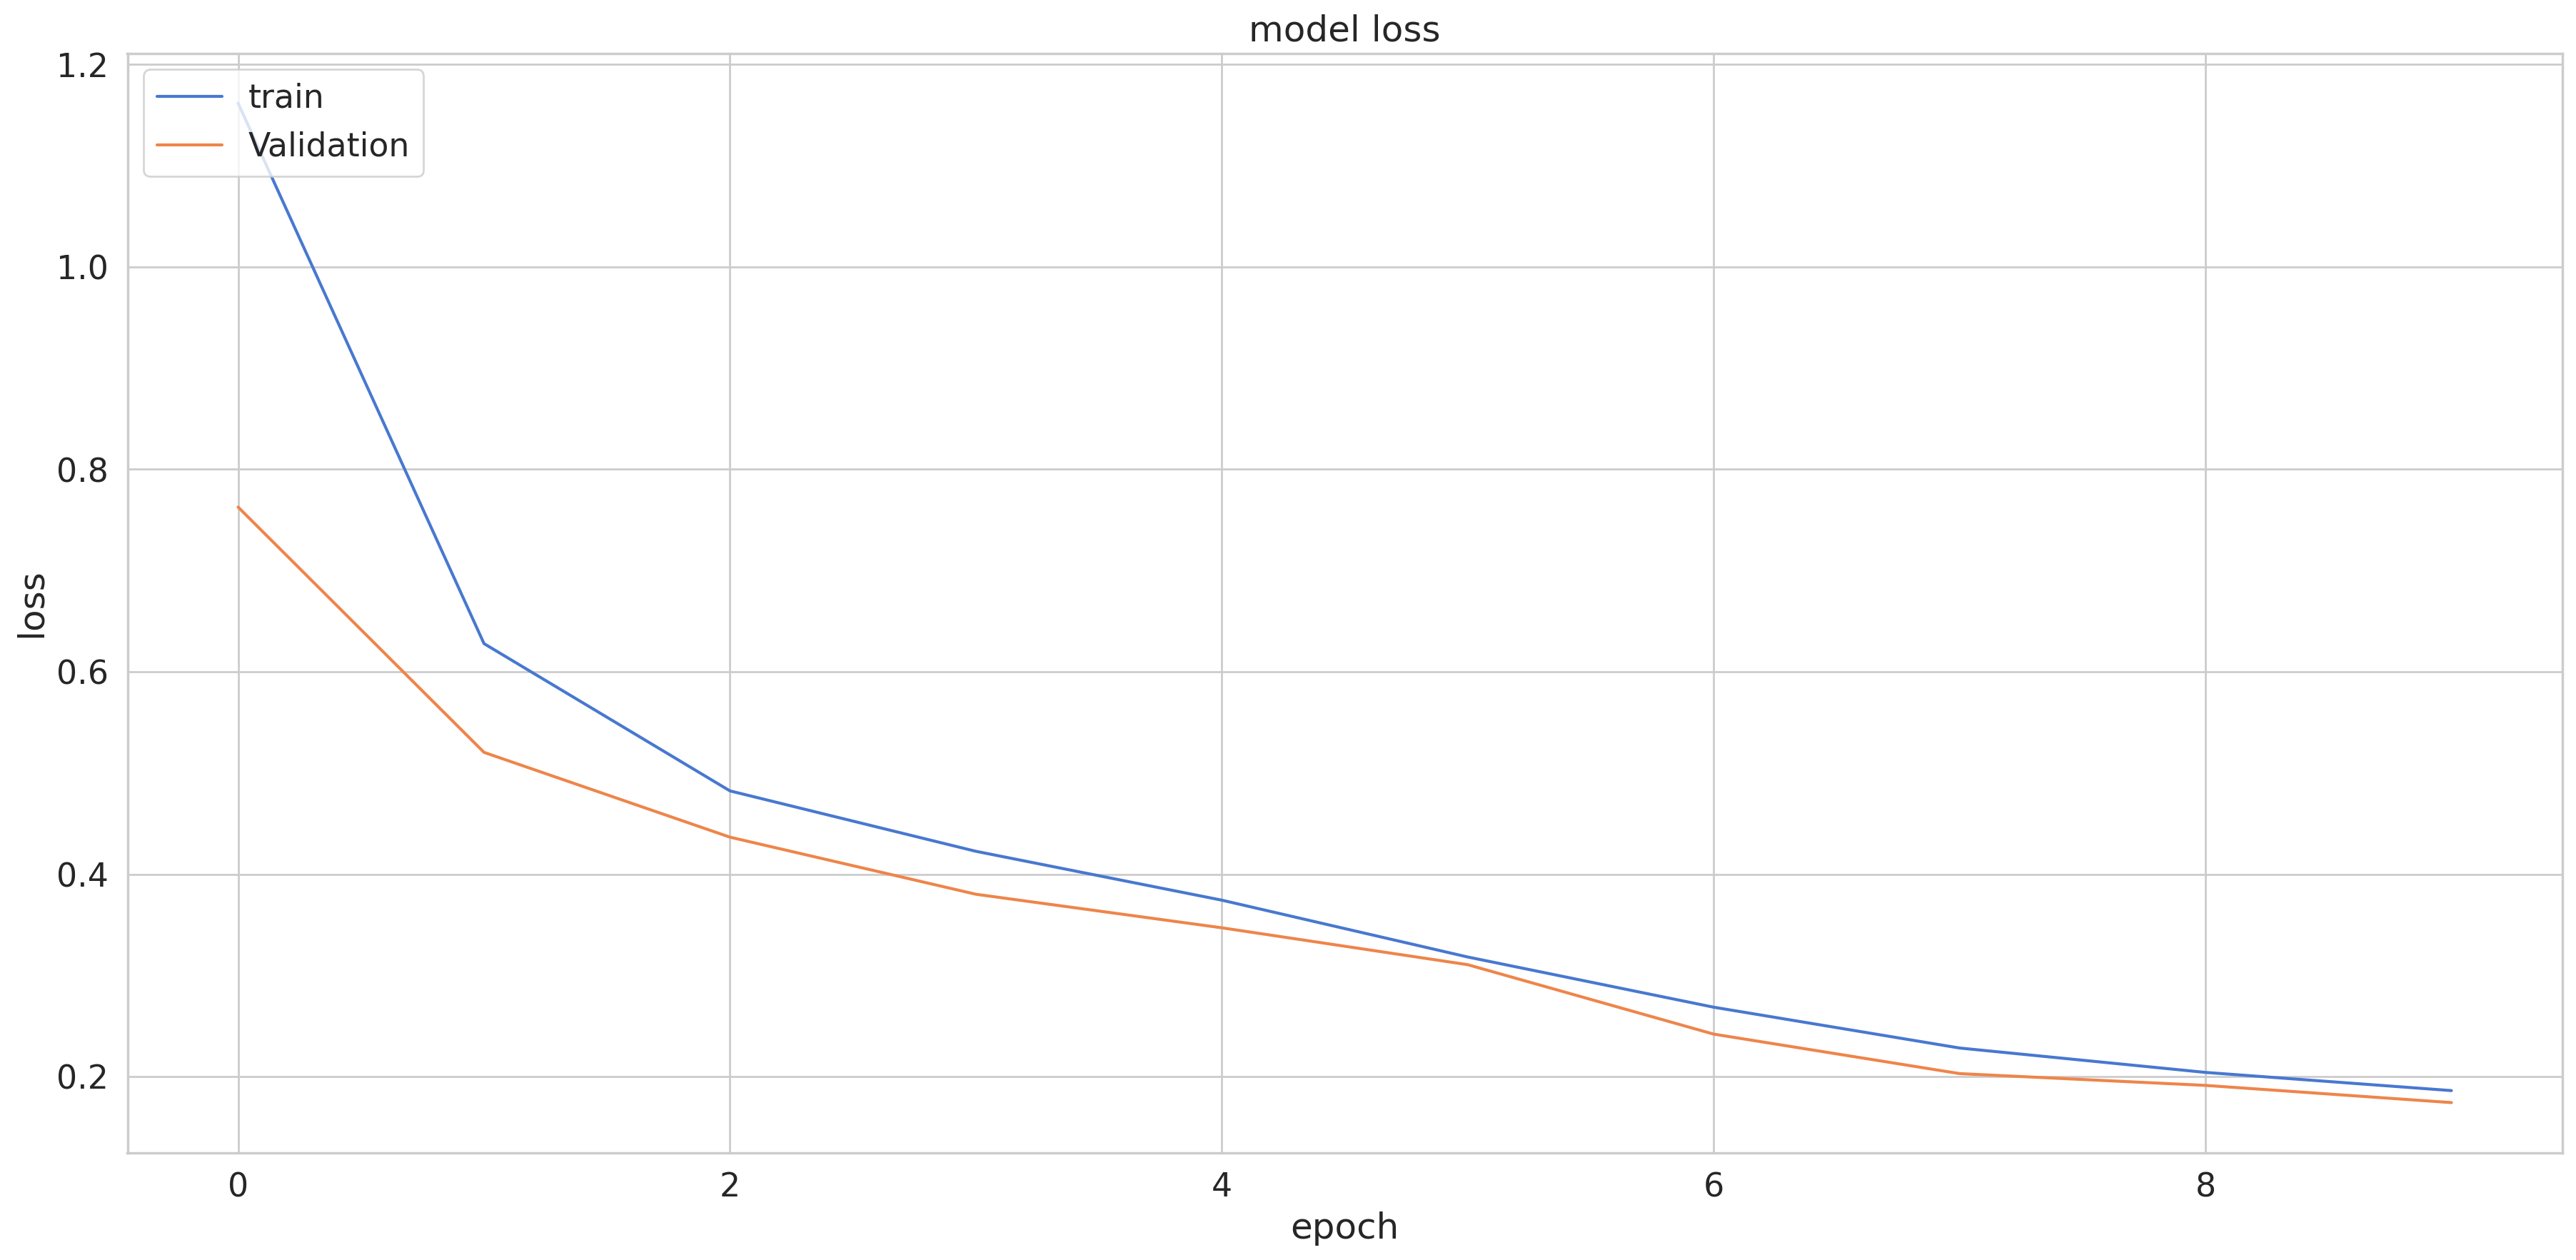

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

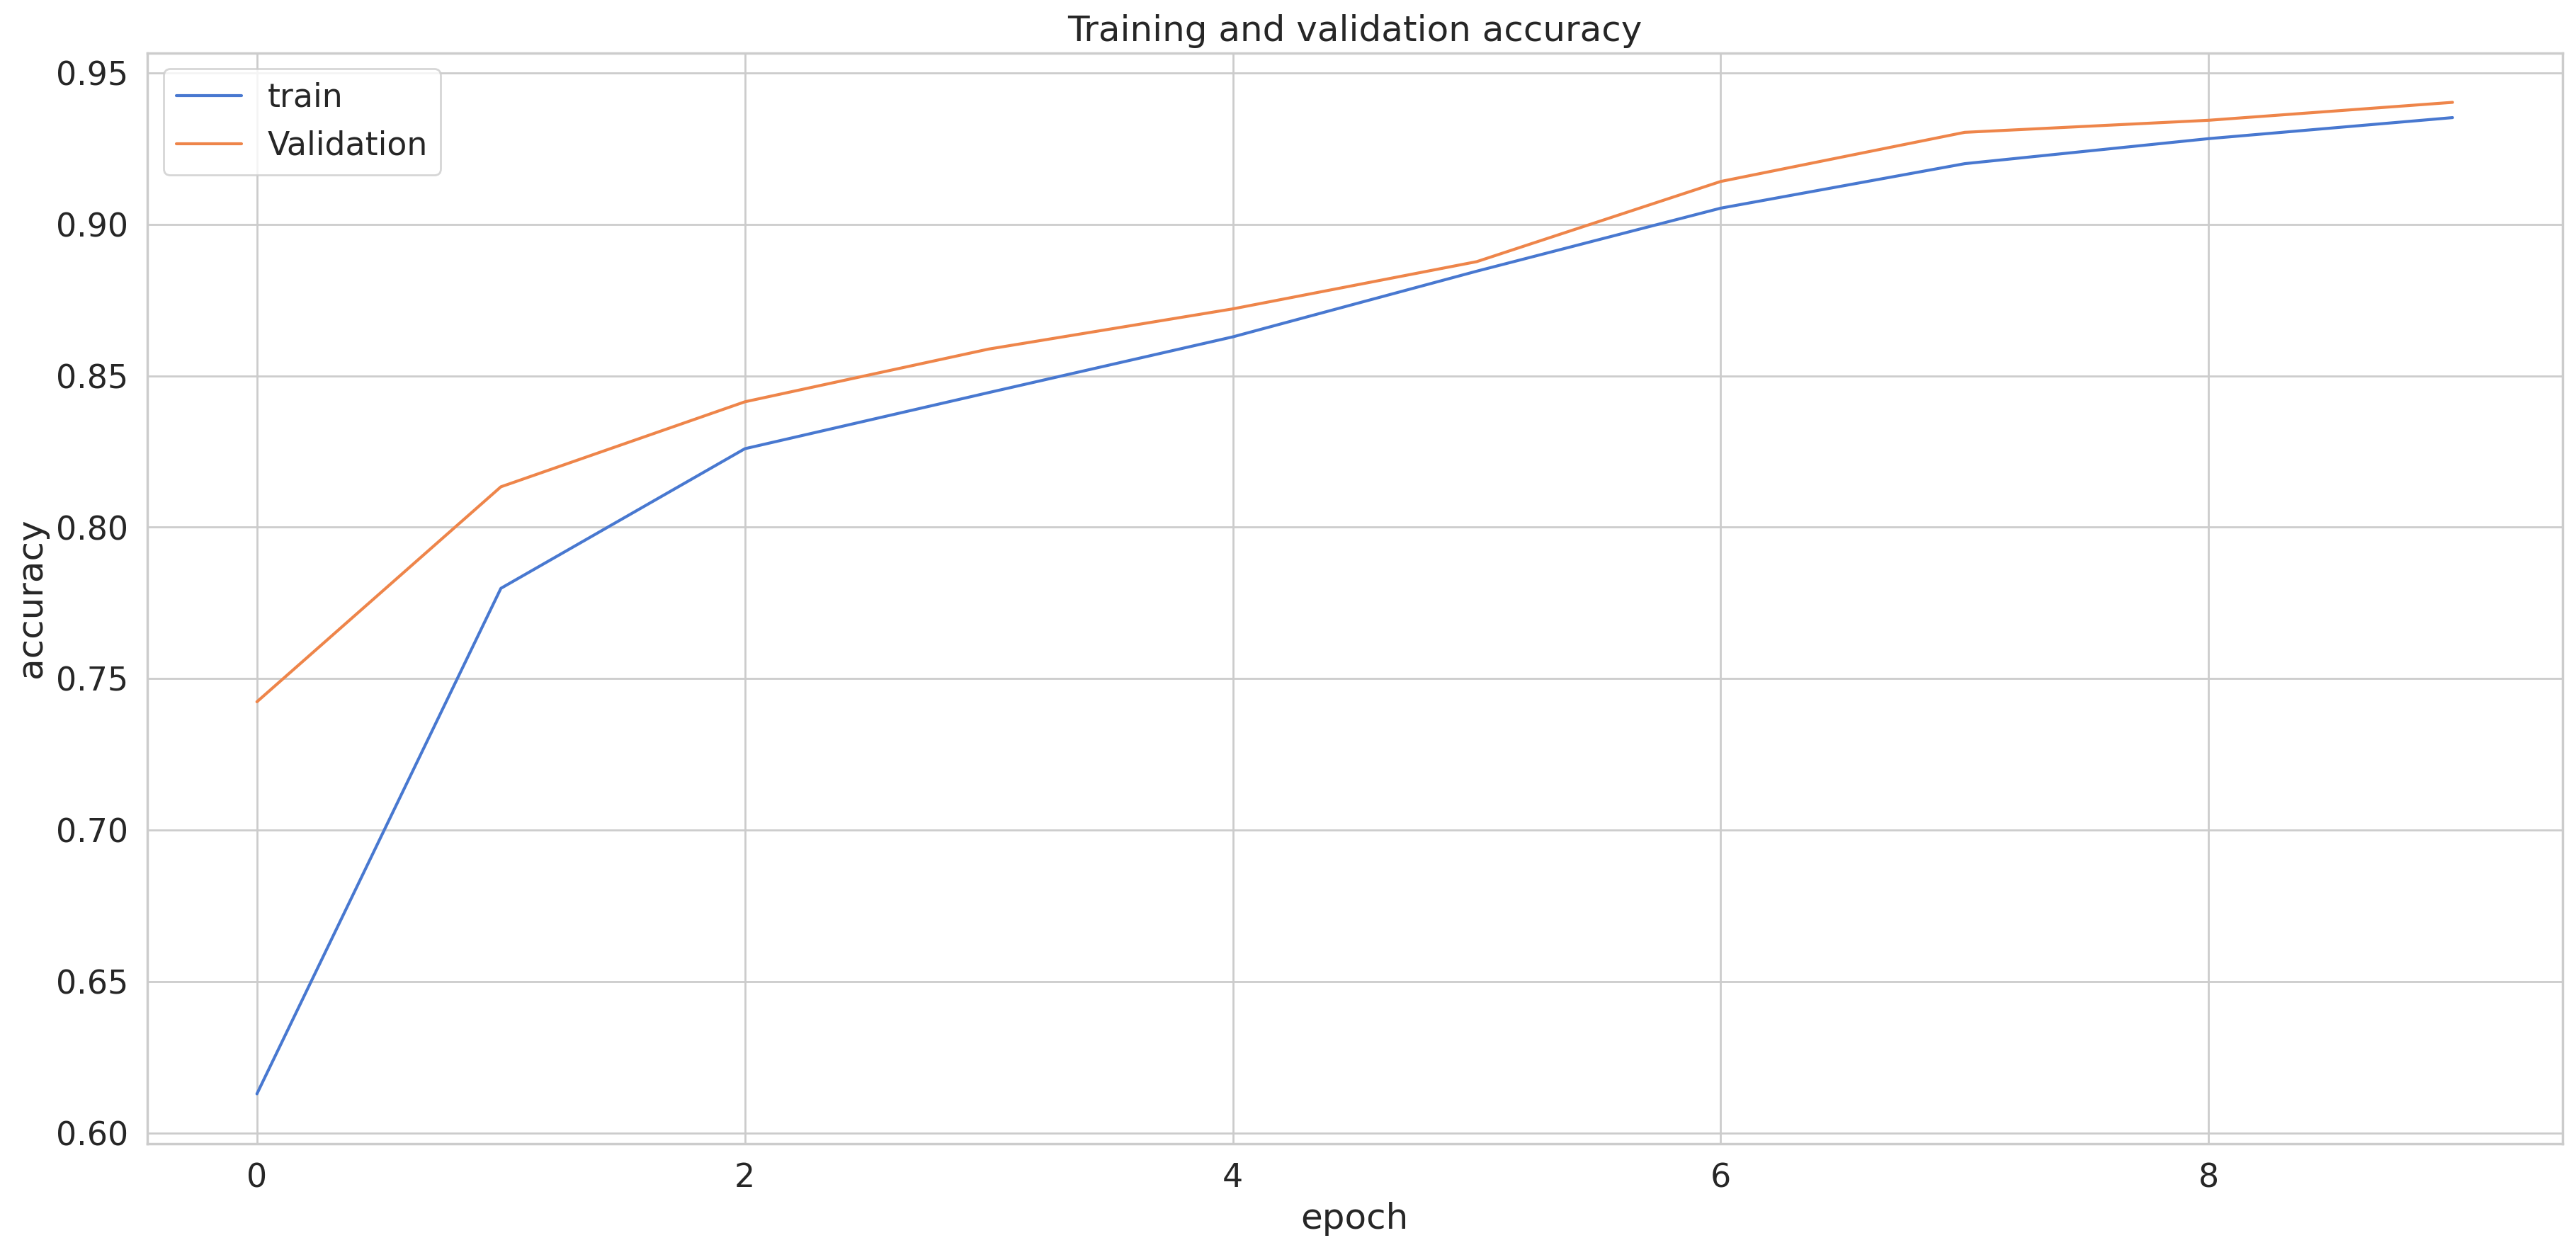

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 3s 4ms/step
f1_score =  0.937476415233805
0.9380804953560371
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8489
           1       0.99      0.97      0.98      6844
           2       0.82      0.81      0.81      2458
           3       0.81      0.76      0.79      2007
           4       0.99      0.94      0.97      1198
           5       0.93      0.99      0.96       968

    accuracy                           0.94     21964
   macro avg       0.92      0.91      0.91     21964
weighted avg       0.94      0.94      0.94     21964



<Axes: >

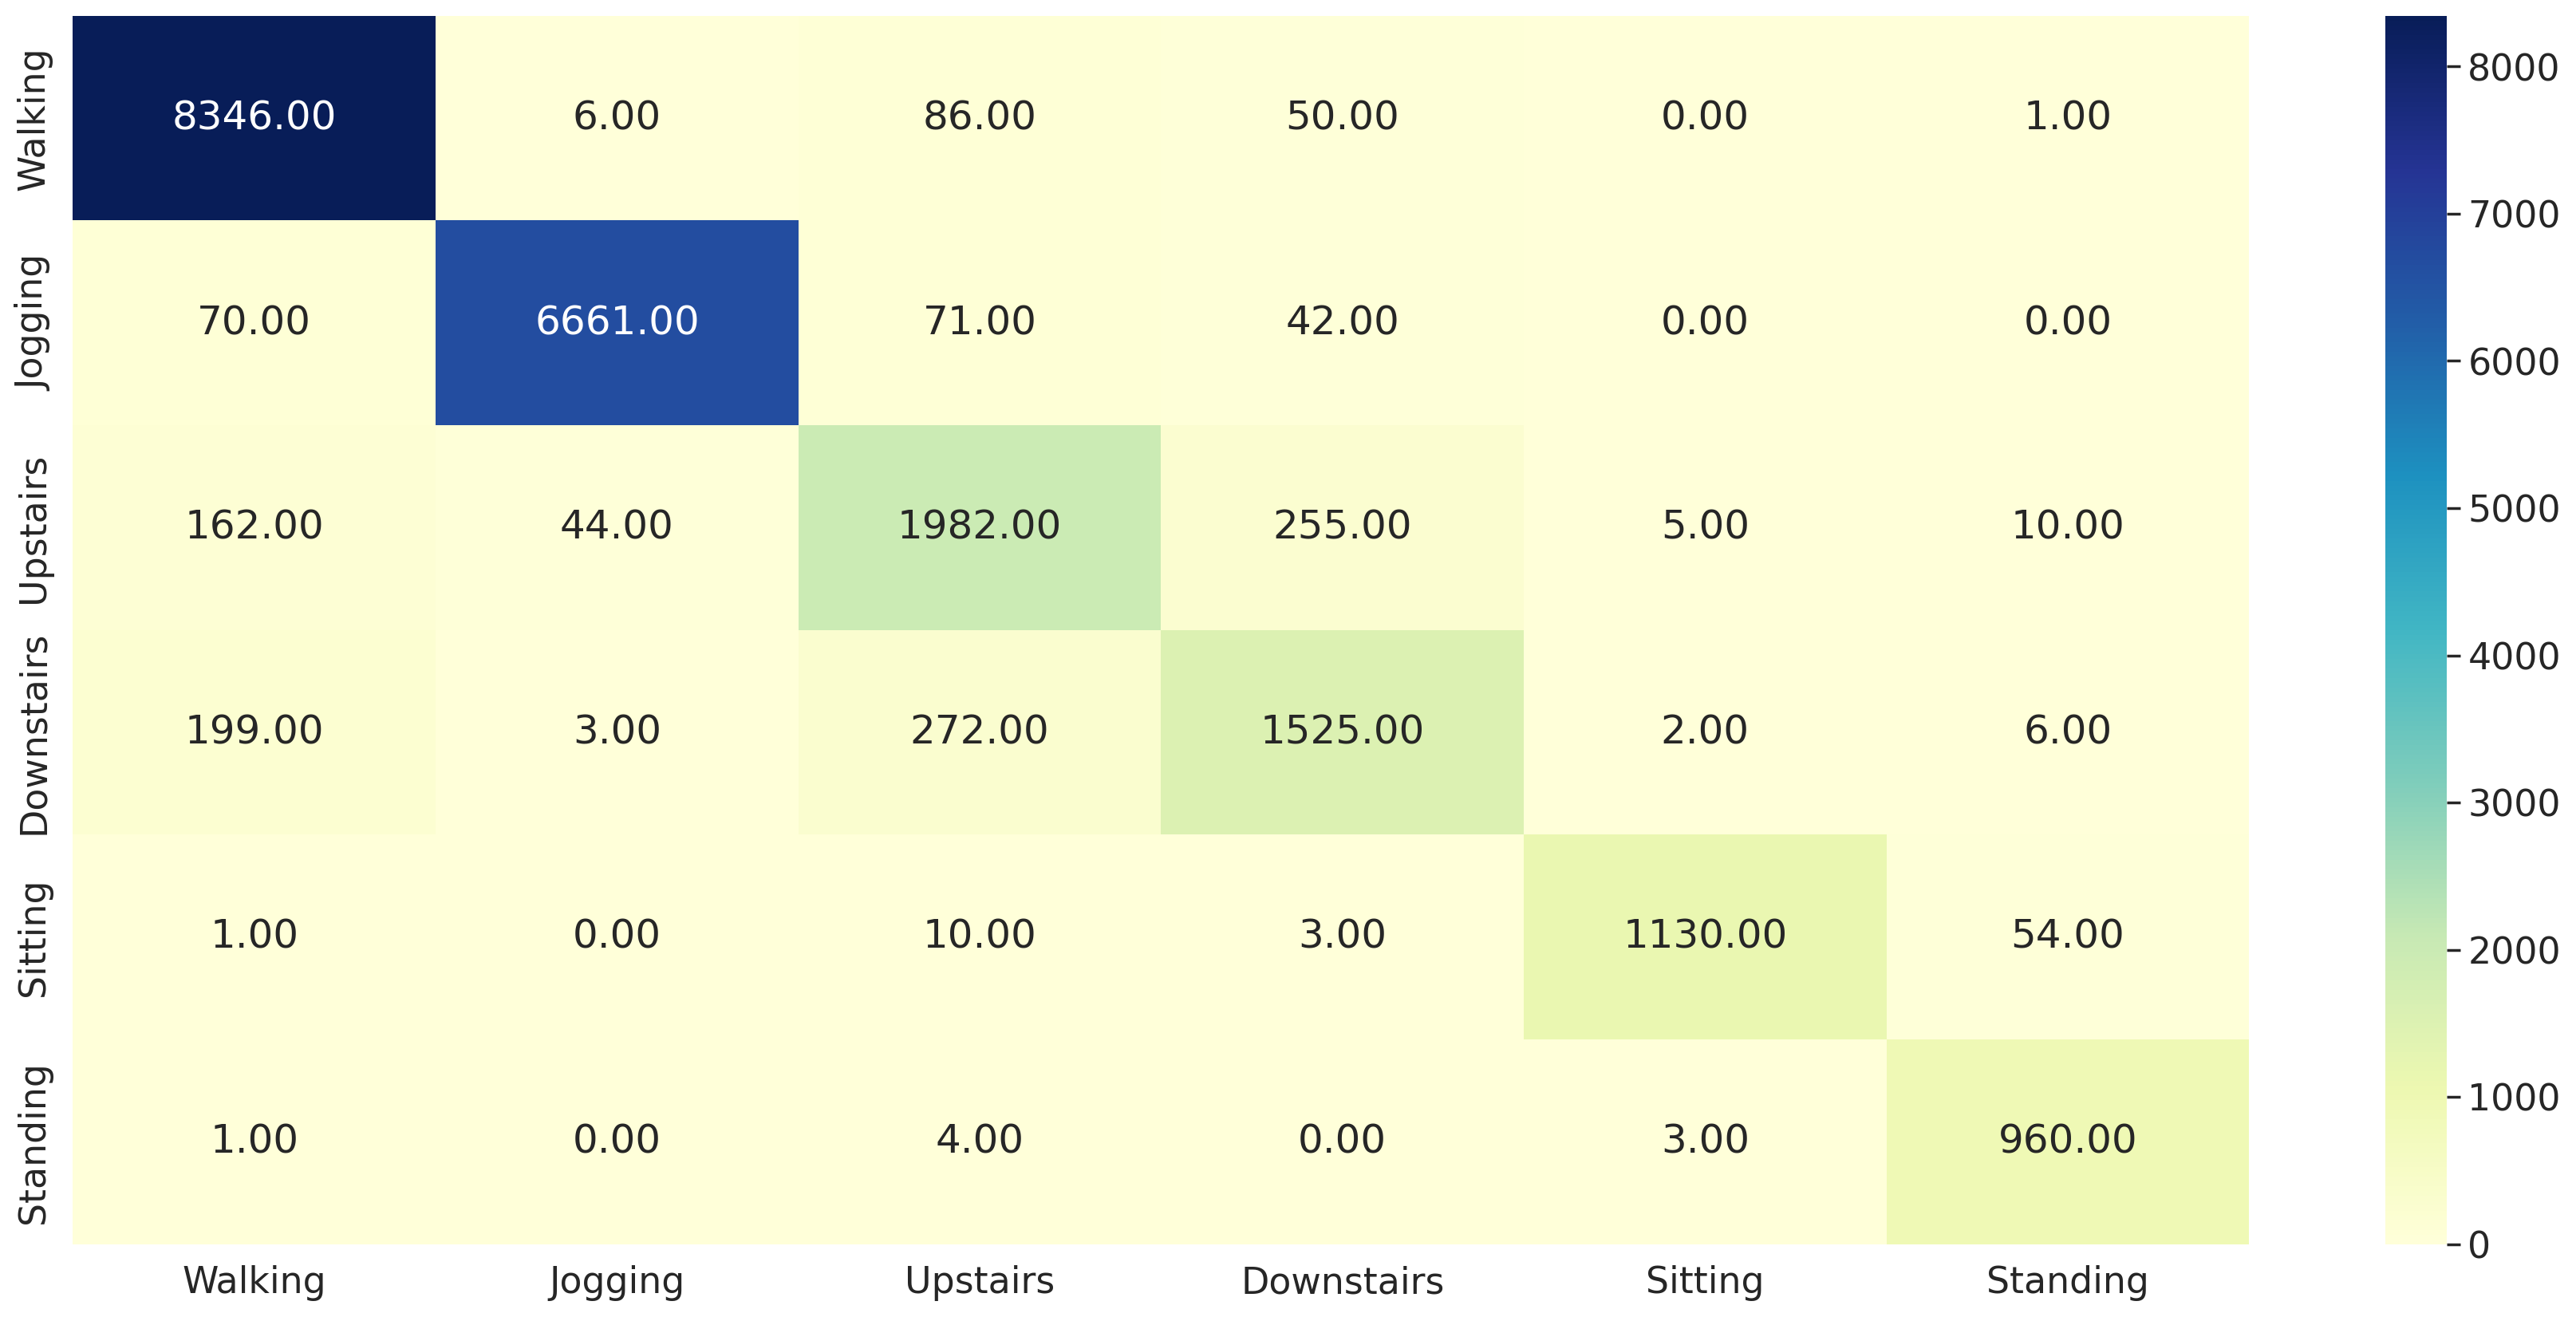

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU2

In [18]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 50, 256)           102144    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 6)                

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 19s 20ms/step - loss: 0.5188 - accuracy: 0.8137 - val_loss: 0.2115 - val_accuracy: 0.9308
Epoch 2/10
550/550 [==============================] - 11s 20ms/step - loss: 0.1734 - accuracy: 0.9439 - val_loss: 0.1202 - val_accuracy: 0.9614
Epoch 3/10
550/550 [==============================] - 10s 19ms/step - loss: 0.1118 - accuracy: 0.9636 - val_loss: 0.0950 - val_accuracy: 0.9721
Epoch 4/10
550/550 [==============================] - 10s 18ms/step - loss: 0.0844 - accuracy: 0.9733 - val_loss: 0.0700 - val_accuracy: 0.9777
Epoch 5/10
550/550 [==============================] - 10s 18ms/step - loss: 0.0664 - accuracy: 0.9794 - val_loss: 0.0558 - val_accuracy: 0.9837
Epoch 6/10
550/550 [==============================] - 11s 19ms/step - loss: 0.0536 - accuracy: 0.9839 - val_loss: 0.0483 - val_accuracy: 0.9861
Epoch 7/10
550/550 [==============================] - 12s 22ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.0499 - val_accuracy:

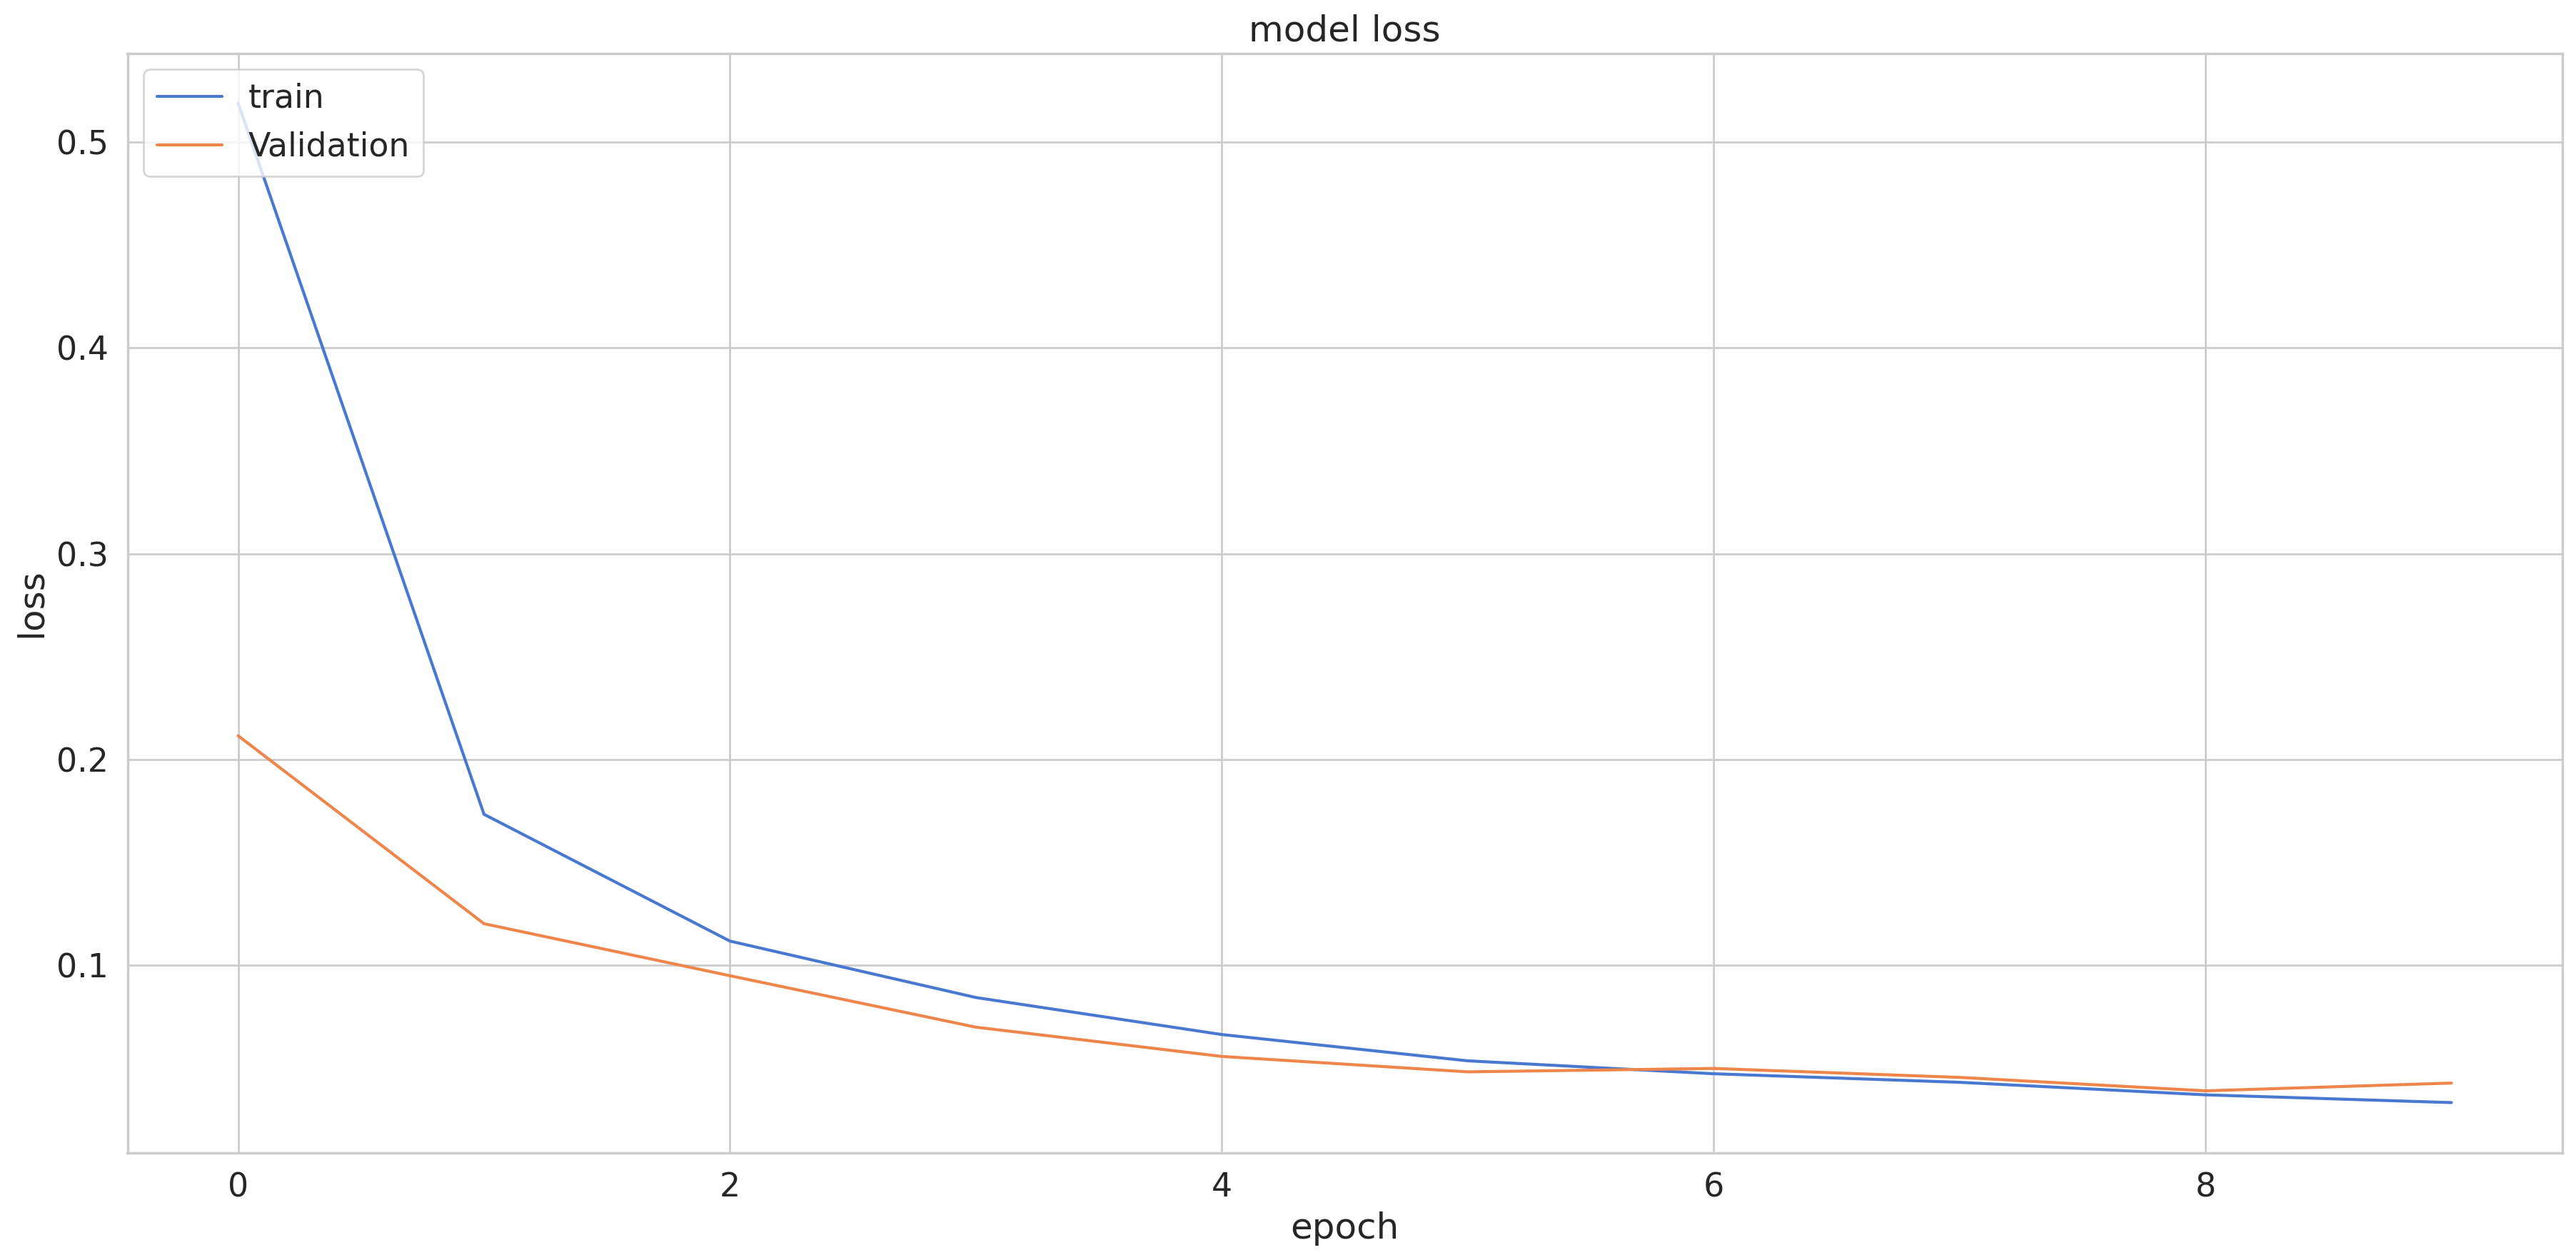

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

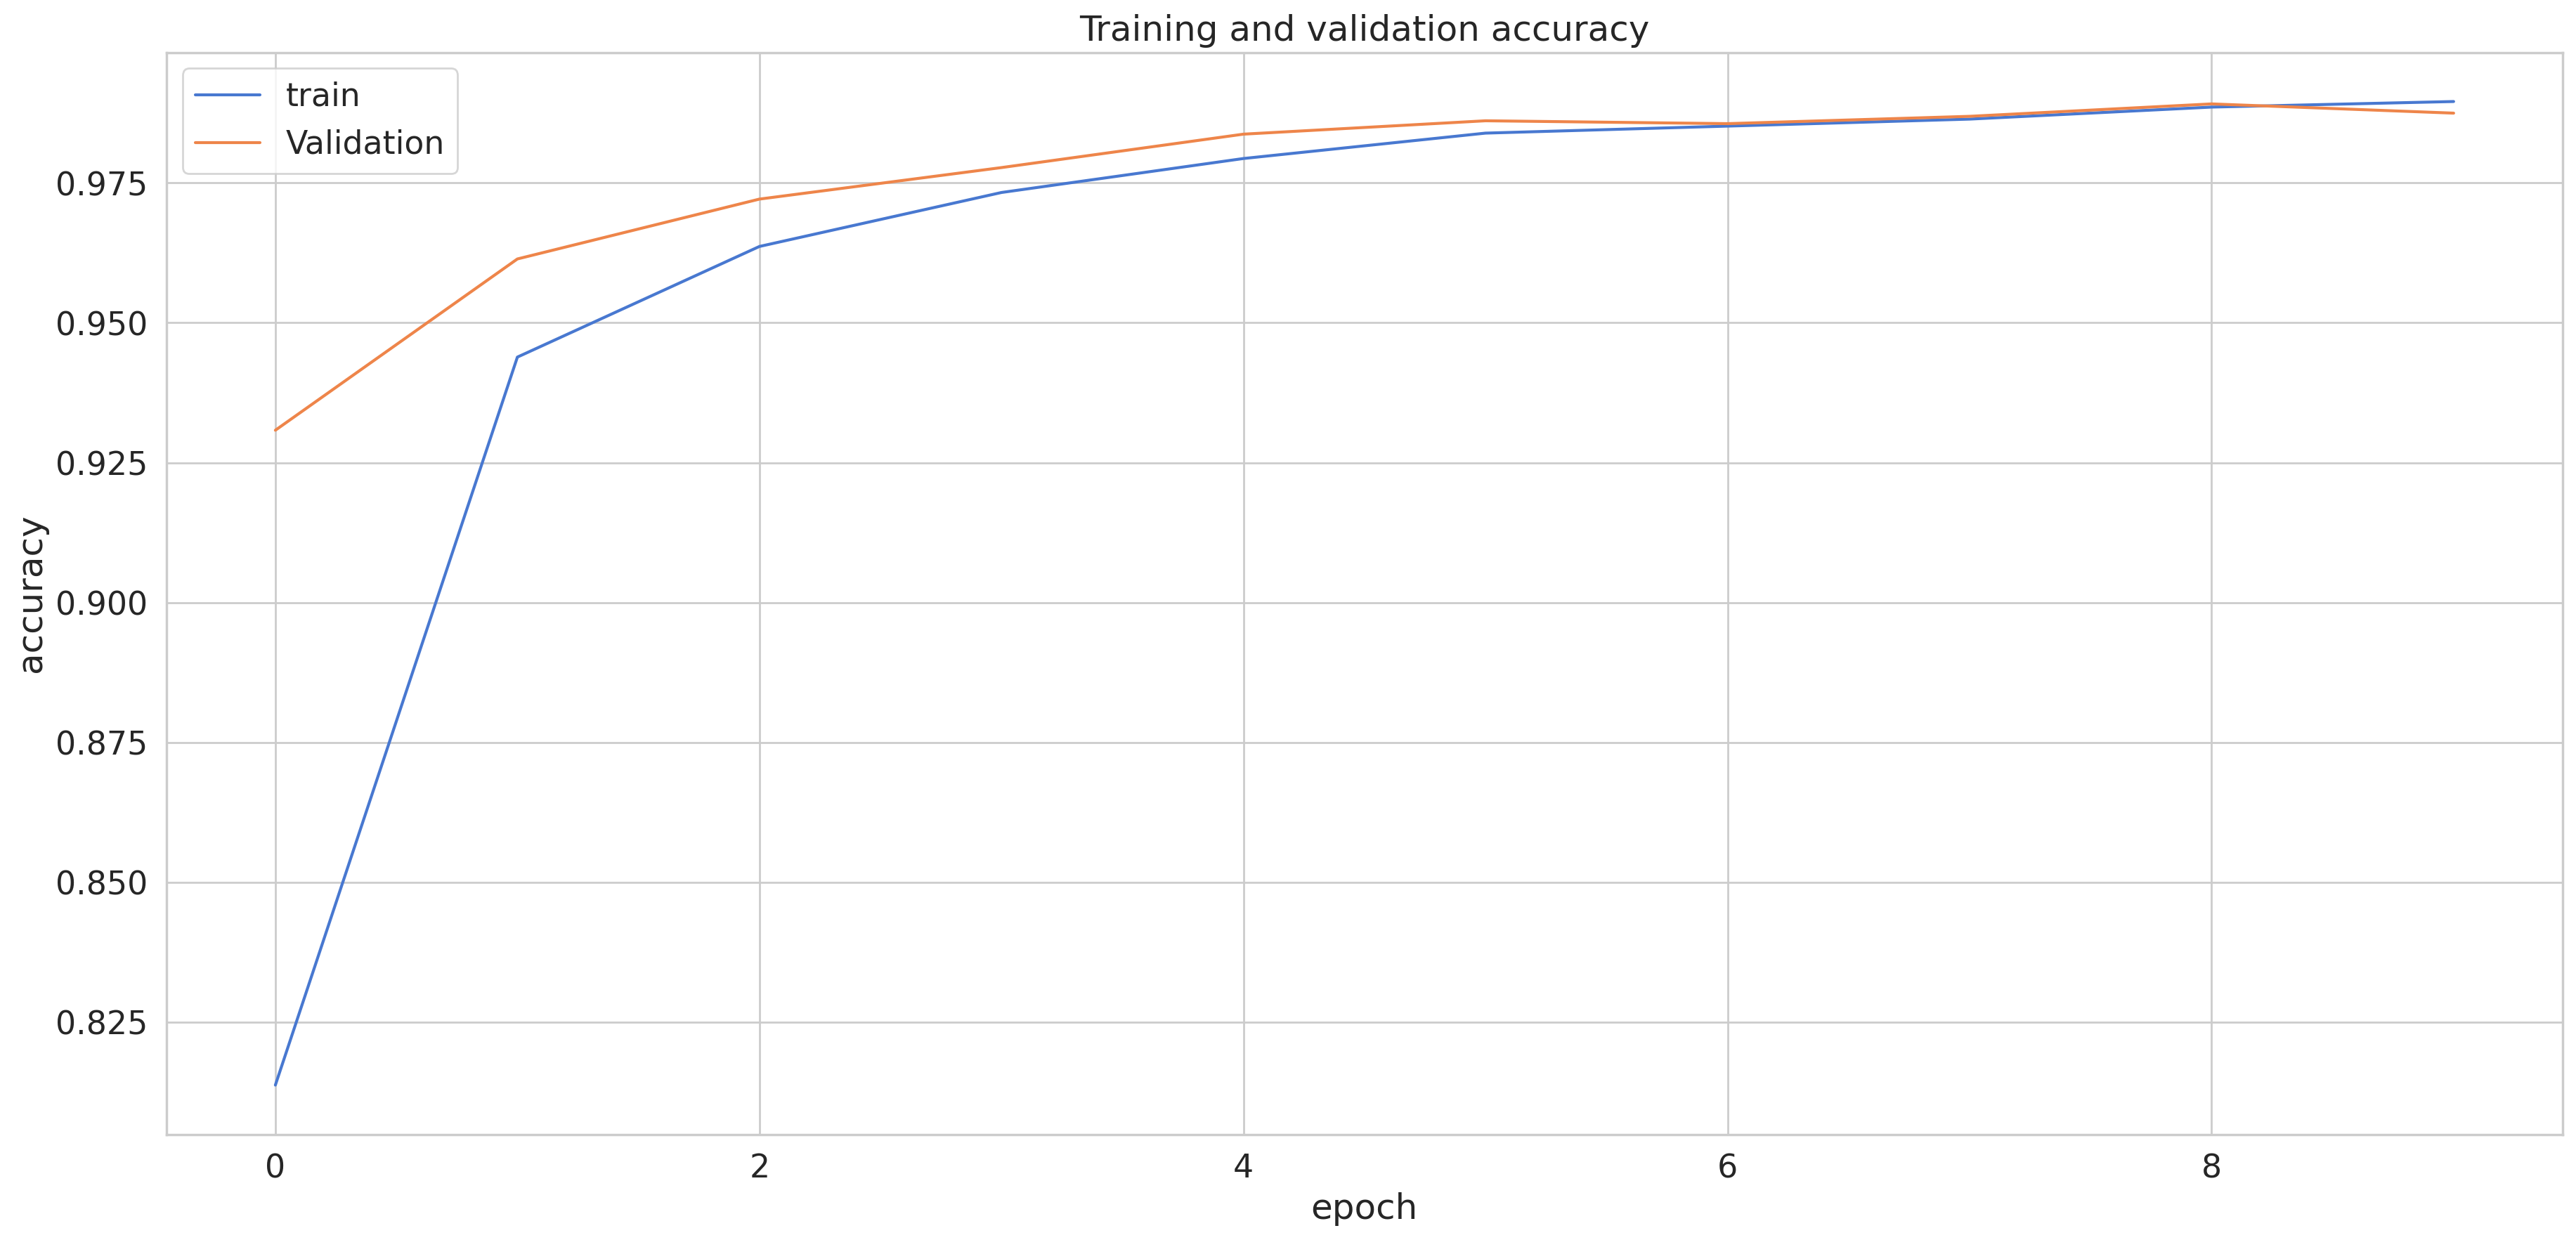

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 6s 6ms/step
f1_score =  0.9858032297332749
0.9857949371699144
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.96      0.95      0.96      2458
           3       0.95      0.96      0.96      2007
           4       0.99      0.98      0.99      1198
           5       0.99      0.99      0.99       968

    accuracy                           0.99     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.99      0.99      0.99     21964



<Axes: >

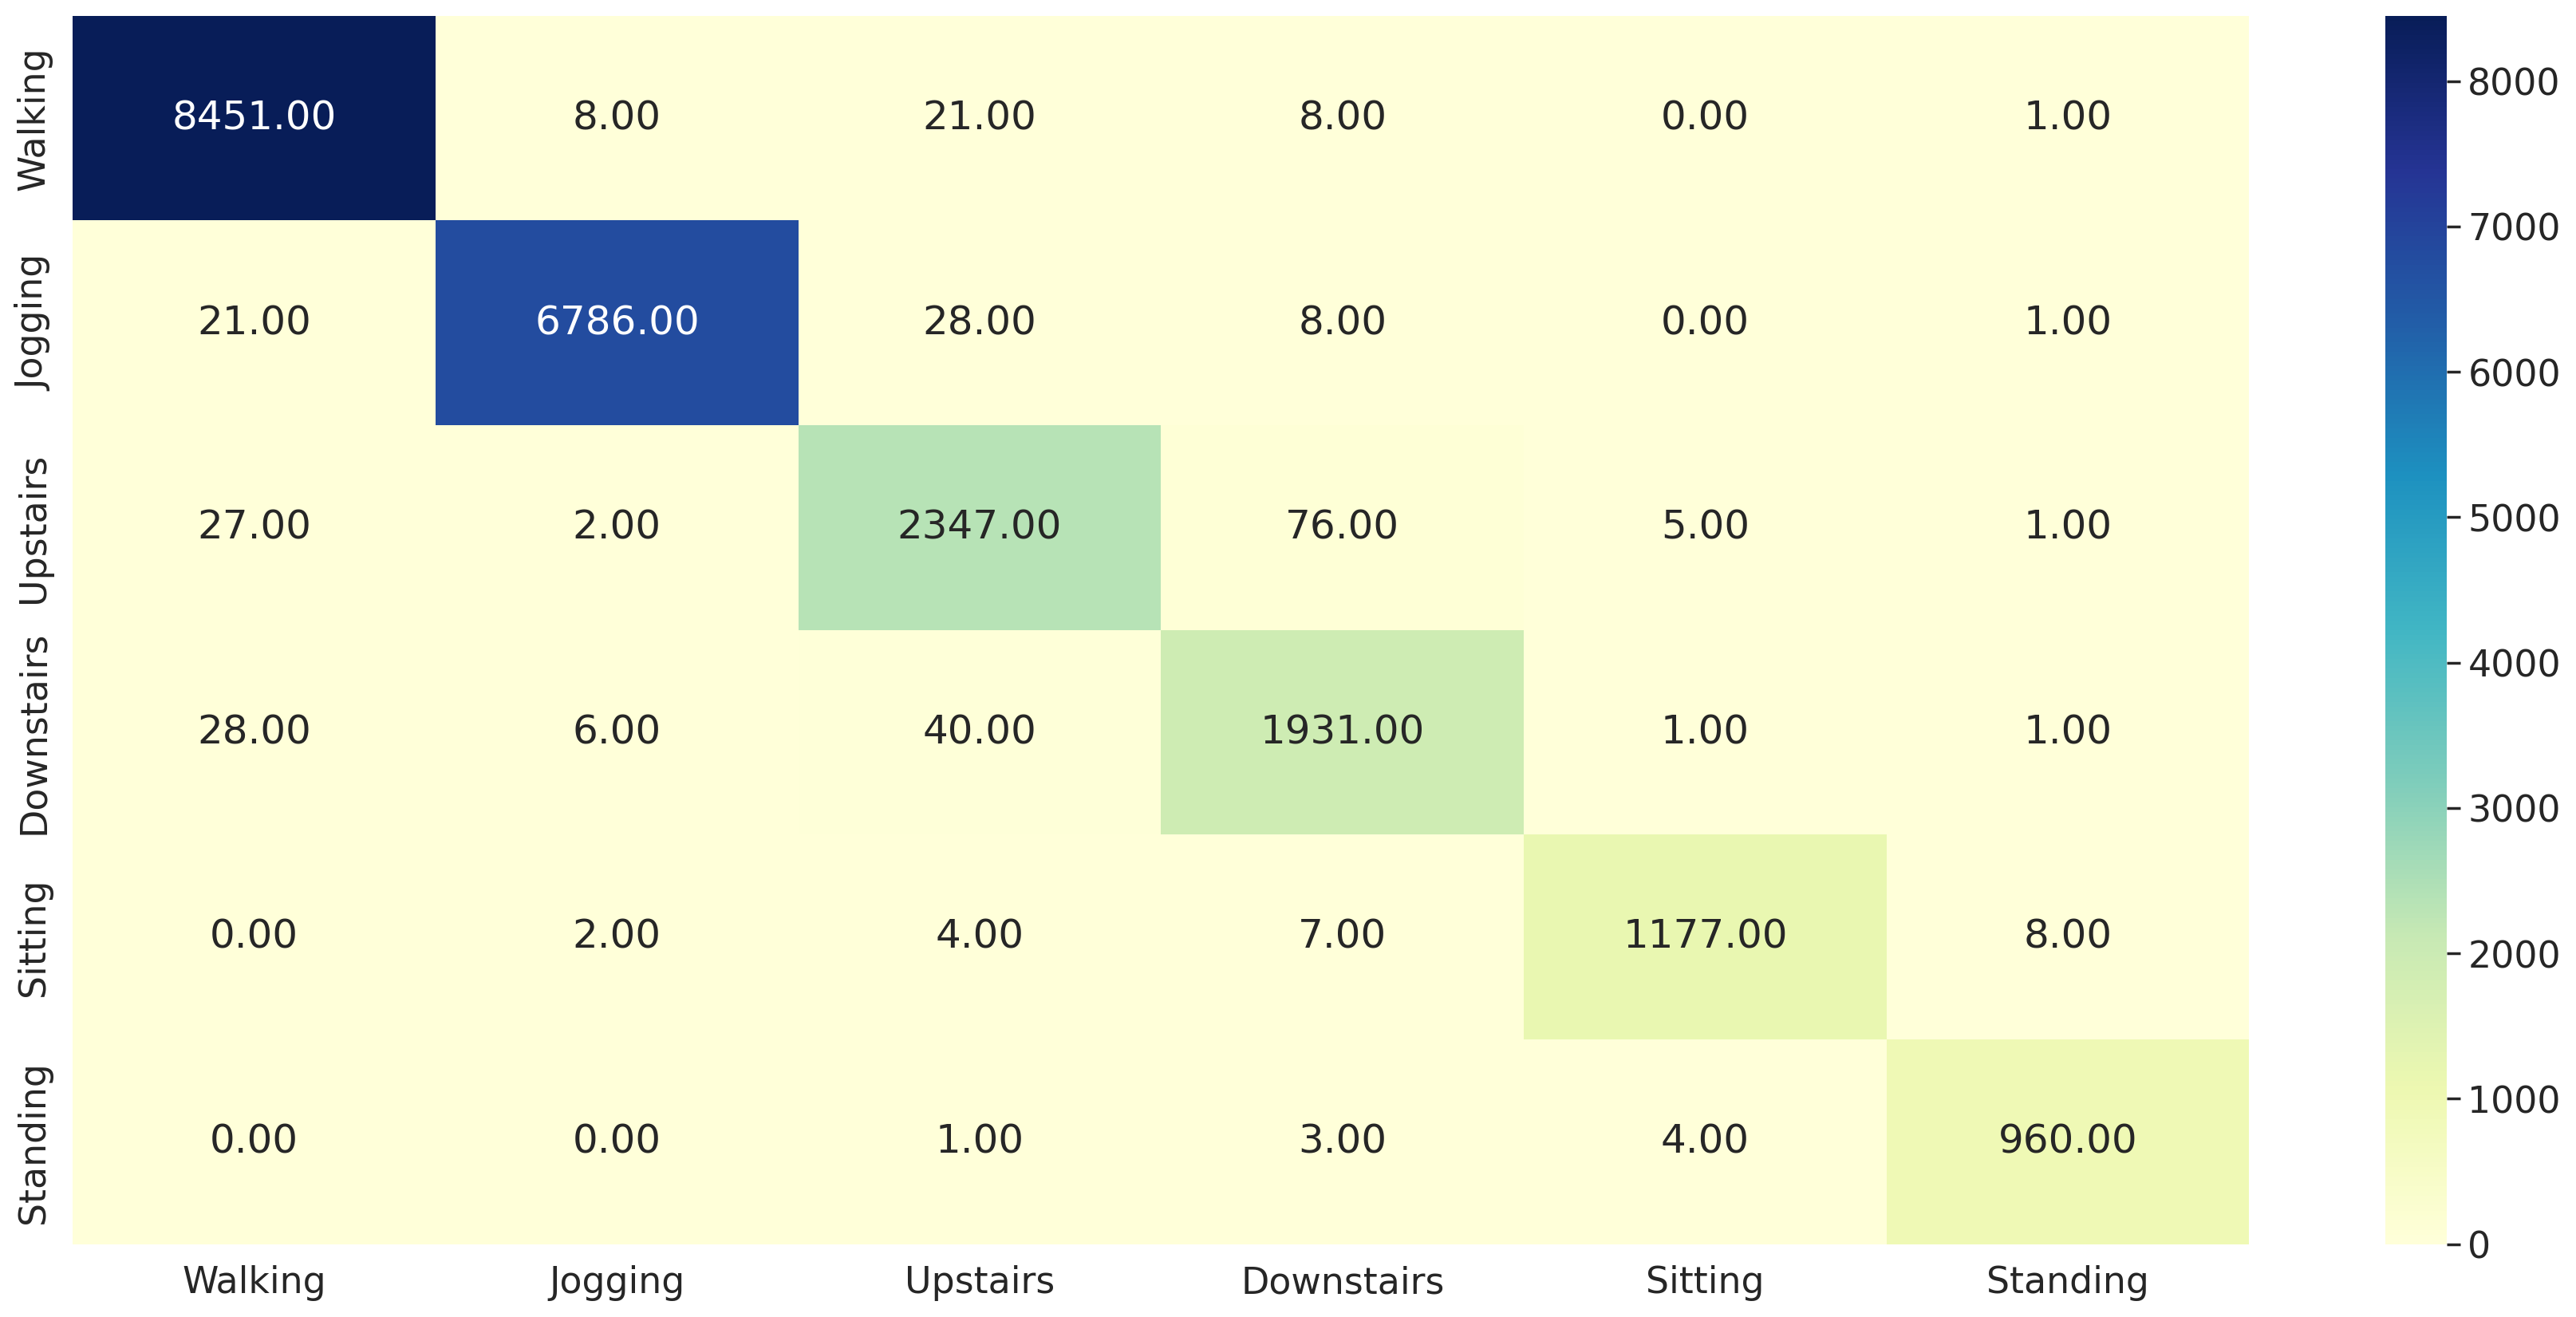

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU3

In [23]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 50, 256)           102144    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 50, 256)           296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 29s 33ms/step - loss: 0.4676 - accuracy: 0.8348 - val_loss: 0.1771 - val_accuracy: 0.9435
Epoch 2/10
550/550 [==============================] - 19s 35ms/step - loss: 0.1446 - accuracy: 0.9531 - val_loss: 0.1190 - val_accuracy: 0.9608
Epoch 3/10
550/550 [==============================] - 15s 27ms/step - loss: 0.0938 - accuracy: 0.9700 - val_loss: 0.0829 - val_accuracy: 0.9760
Epoch 4/10
550/550 [==============================] - 15s 27ms/step - loss: 0.0704 - accuracy: 0.9778 - val_loss: 0.0756 - val_accuracy: 0.9768
Epoch 5/10
550/550 [==============================] - 15s 27ms/step - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.0487 - val_accuracy: 0.9850
Epoch 6/10
550/550 [==============================] - 17s 31ms/step - loss: 0.0475 - accuracy: 0.9849 - val_loss: 0.0459 - val_accuracy: 0.9866
Epoch 7/10
550/550 [==============================] - 15s 28ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.0497 - val_accuracy:

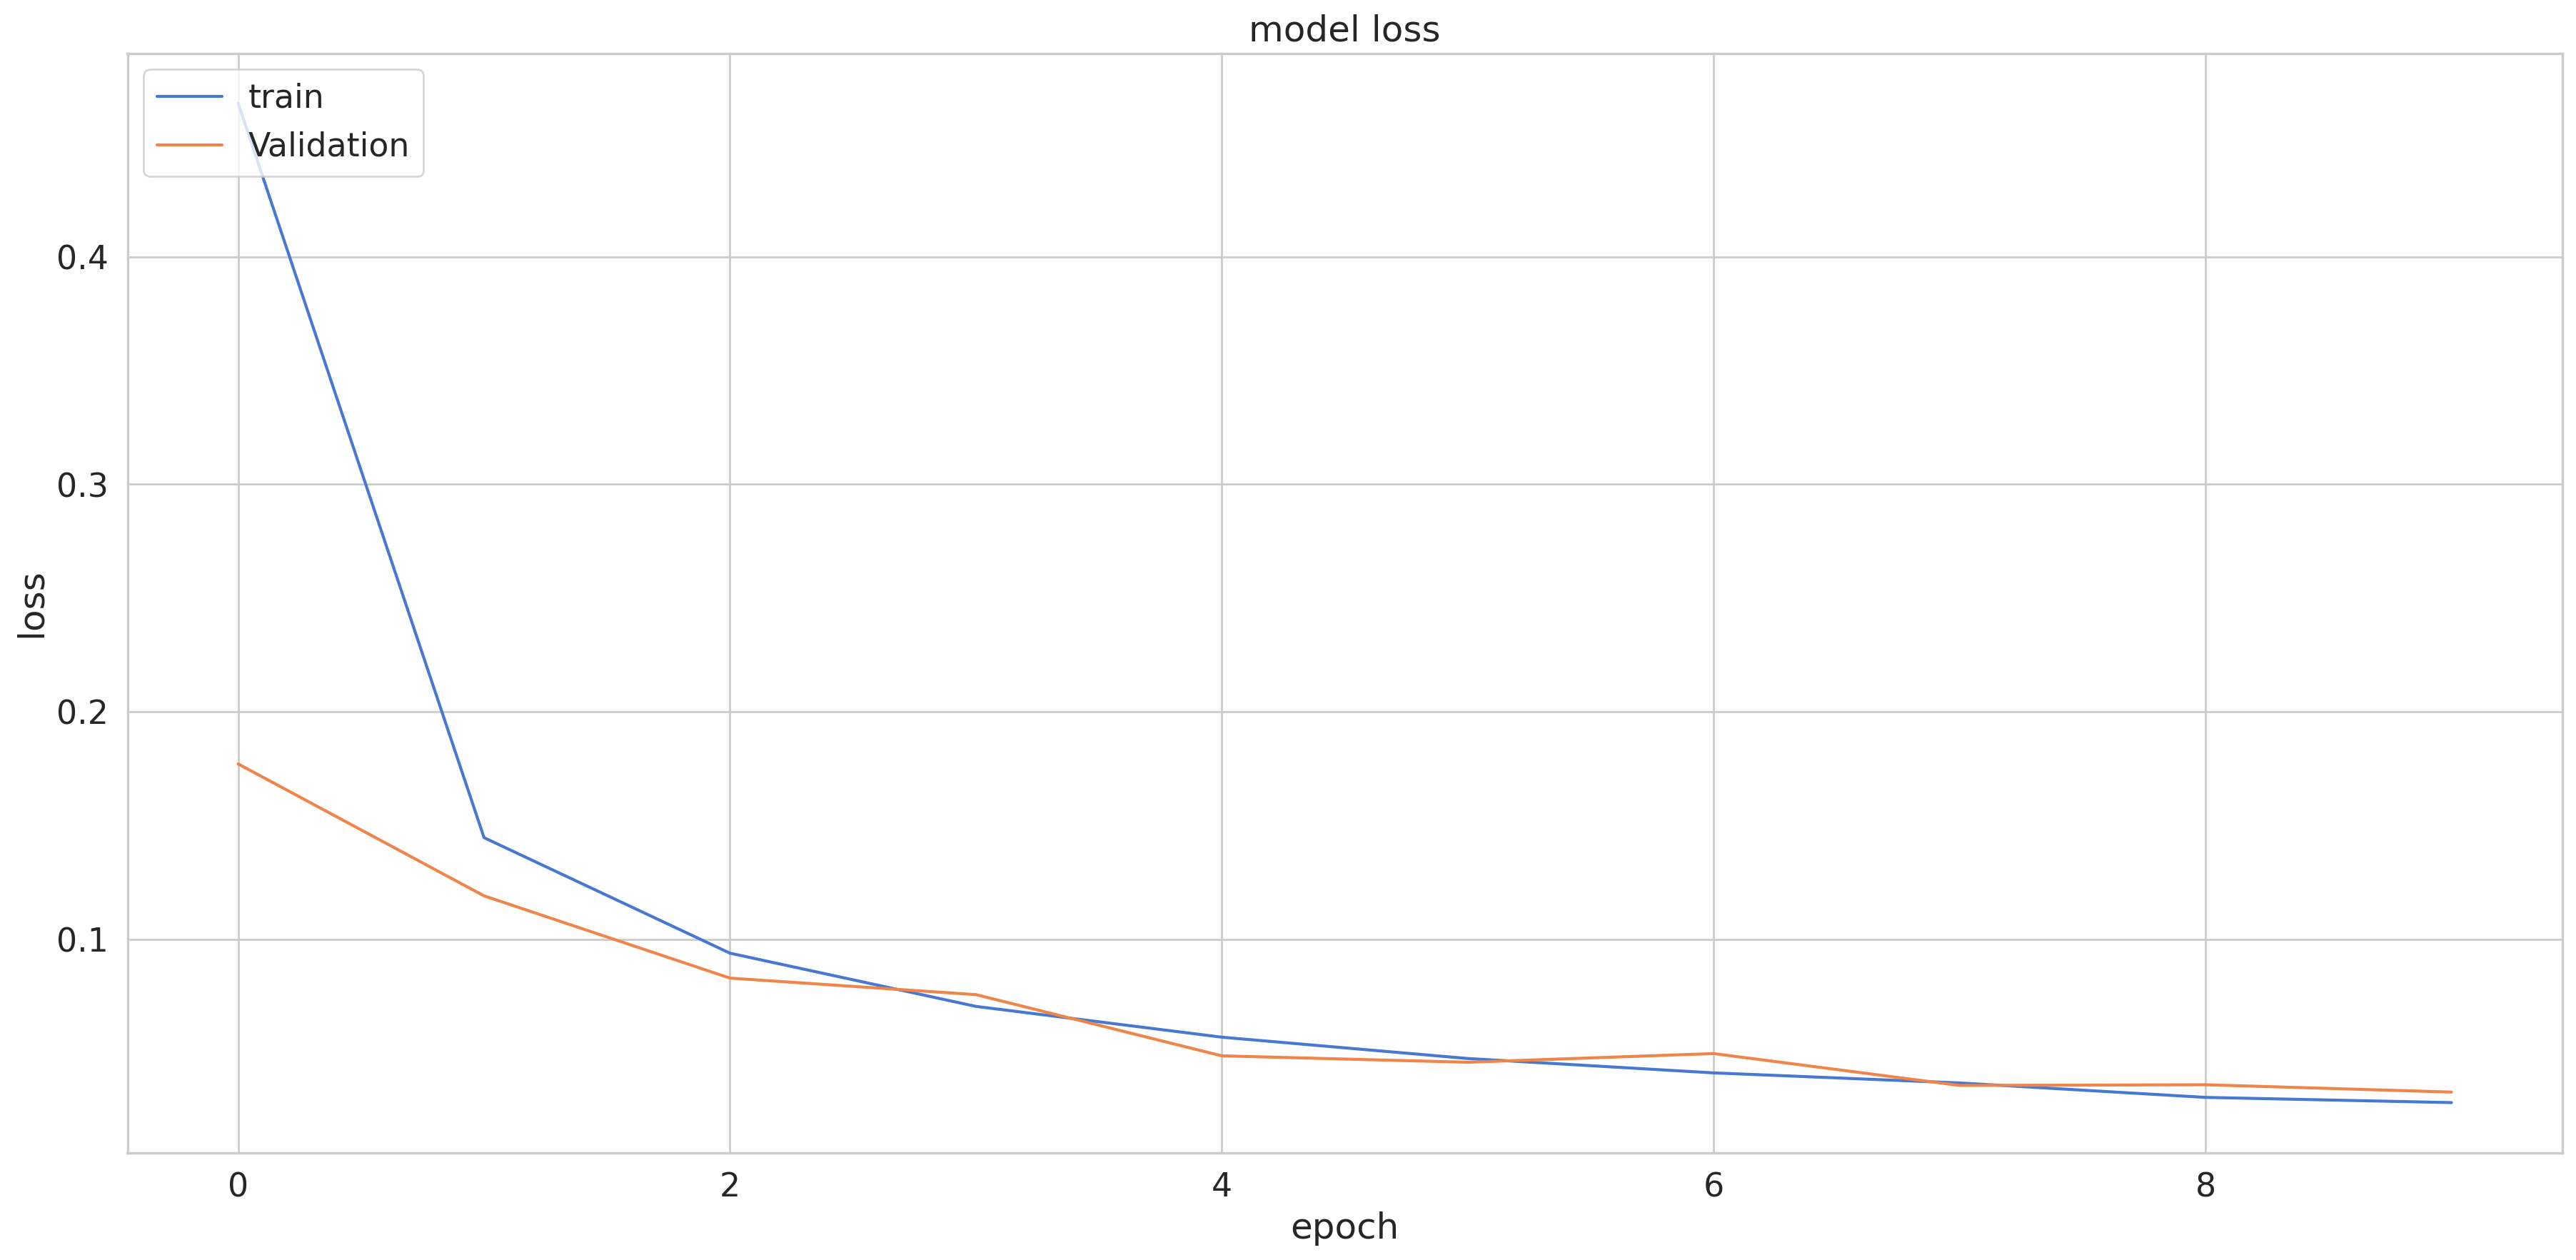

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

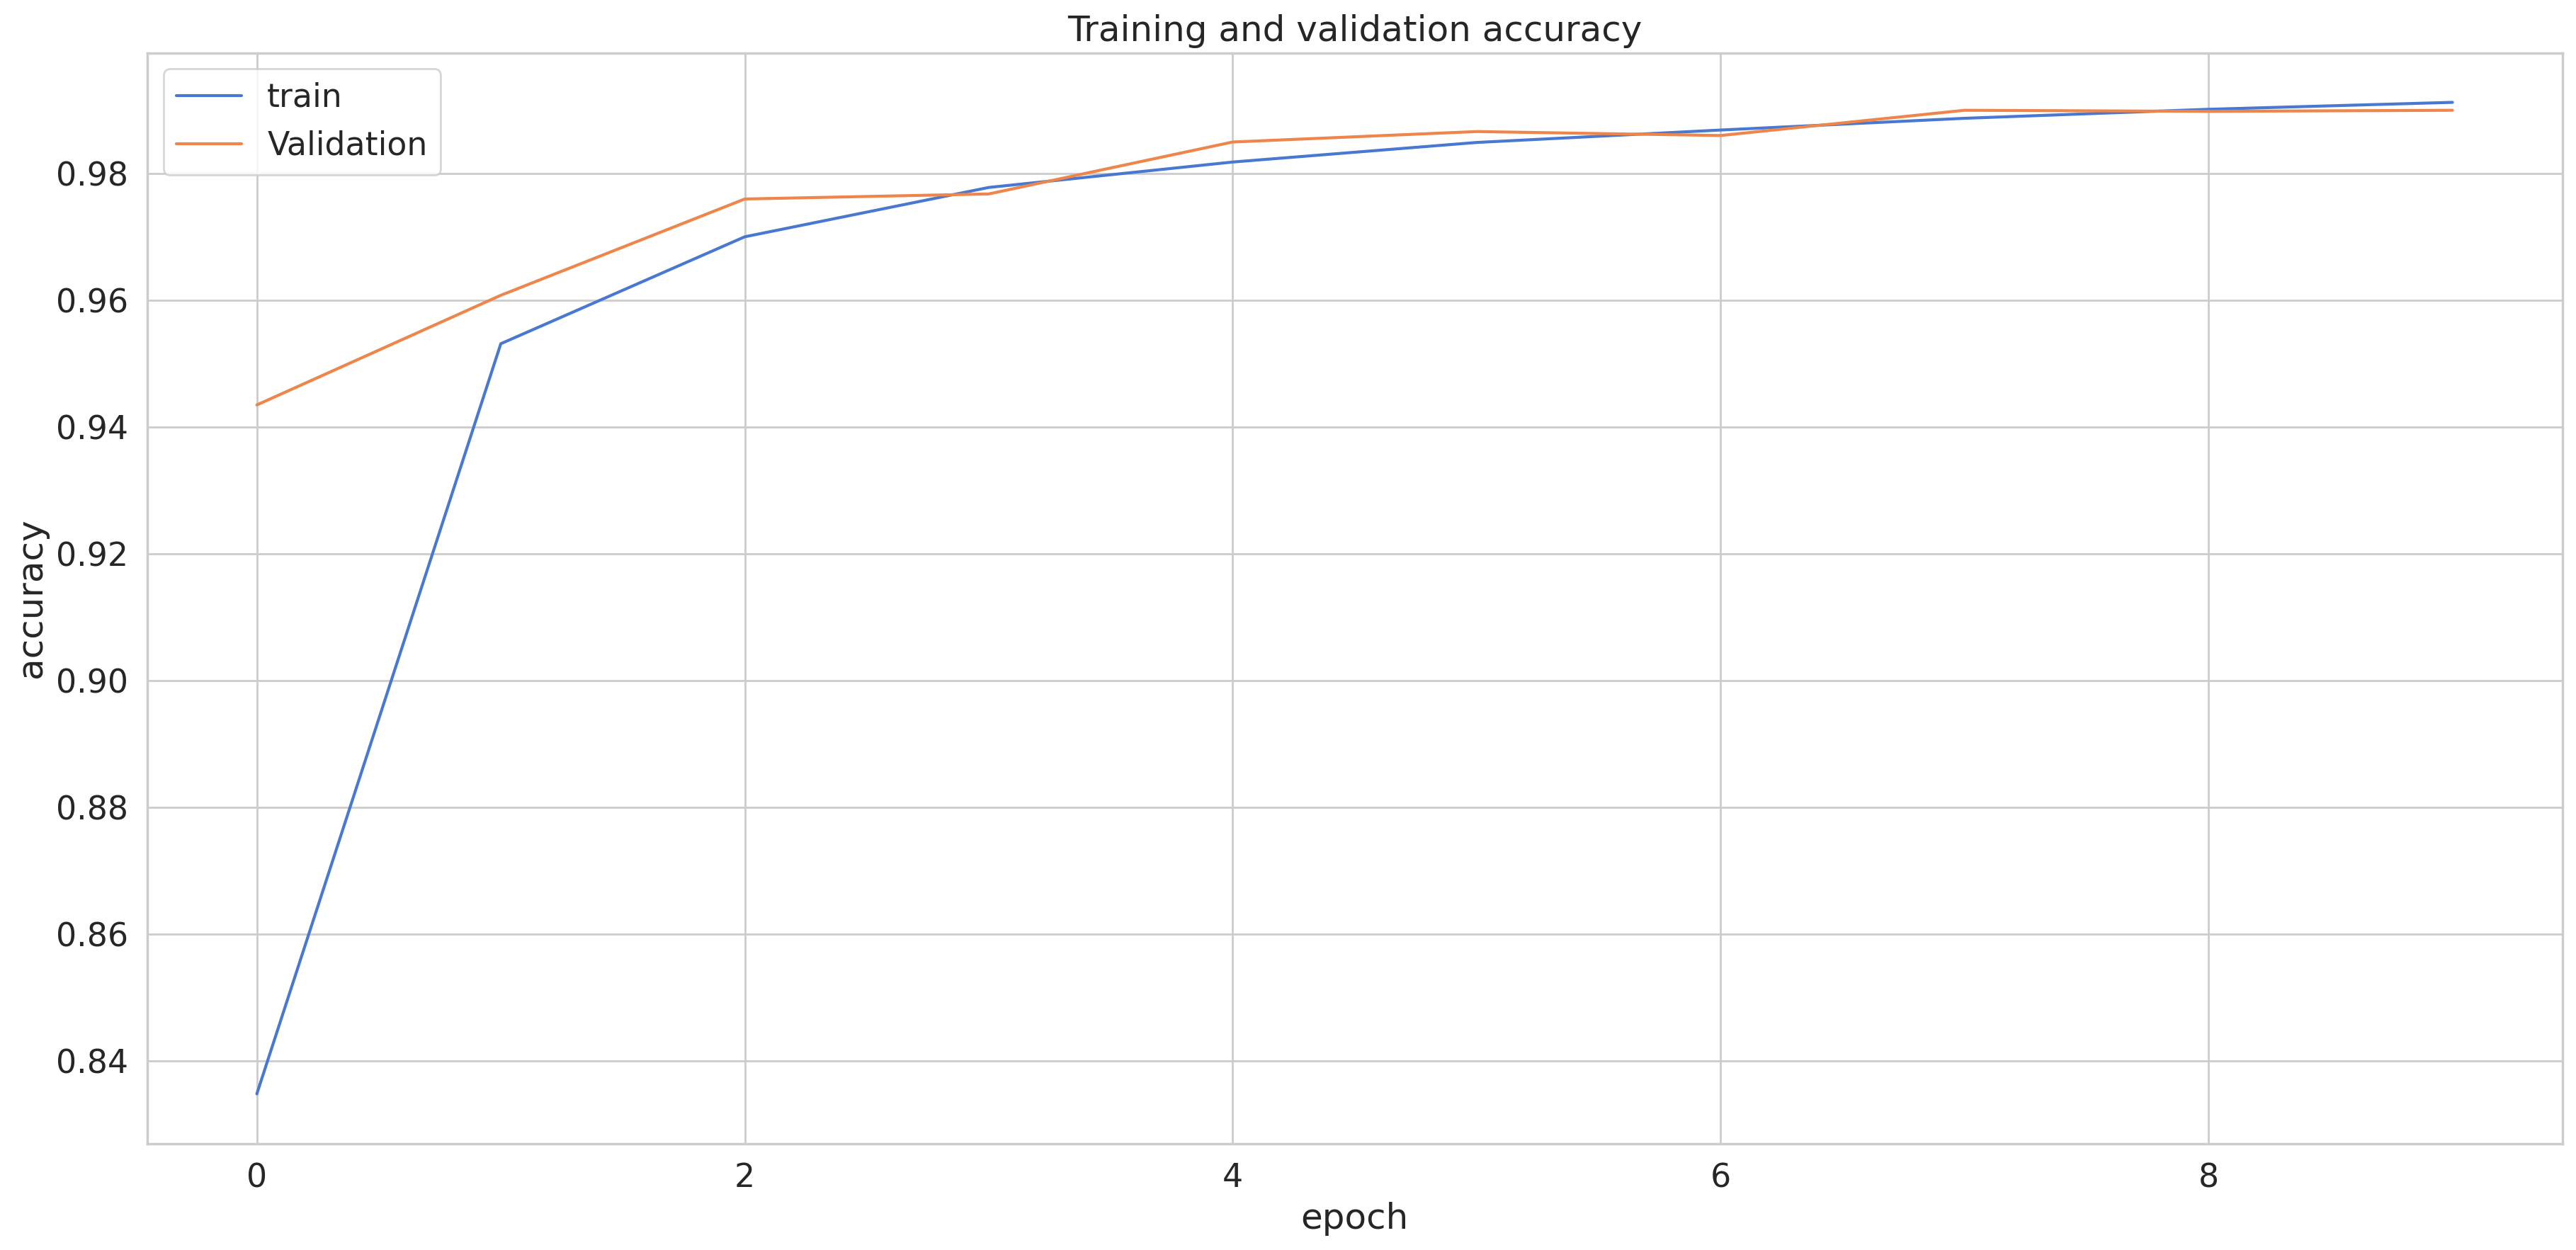

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 9s 9ms/step
f1_score =  0.9894686913322994
0.9894372609725005
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8489
           1       1.00      0.99      1.00      6844
           2       0.97      0.98      0.97      2458
           3       0.96      0.98      0.97      2007
           4       0.99      0.98      0.99      1198
           5       0.98      0.99      0.99       968

    accuracy                           0.99     21964
   macro avg       0.98      0.99      0.98     21964
weighted avg       0.99      0.99      0.99     21964



<Axes: >

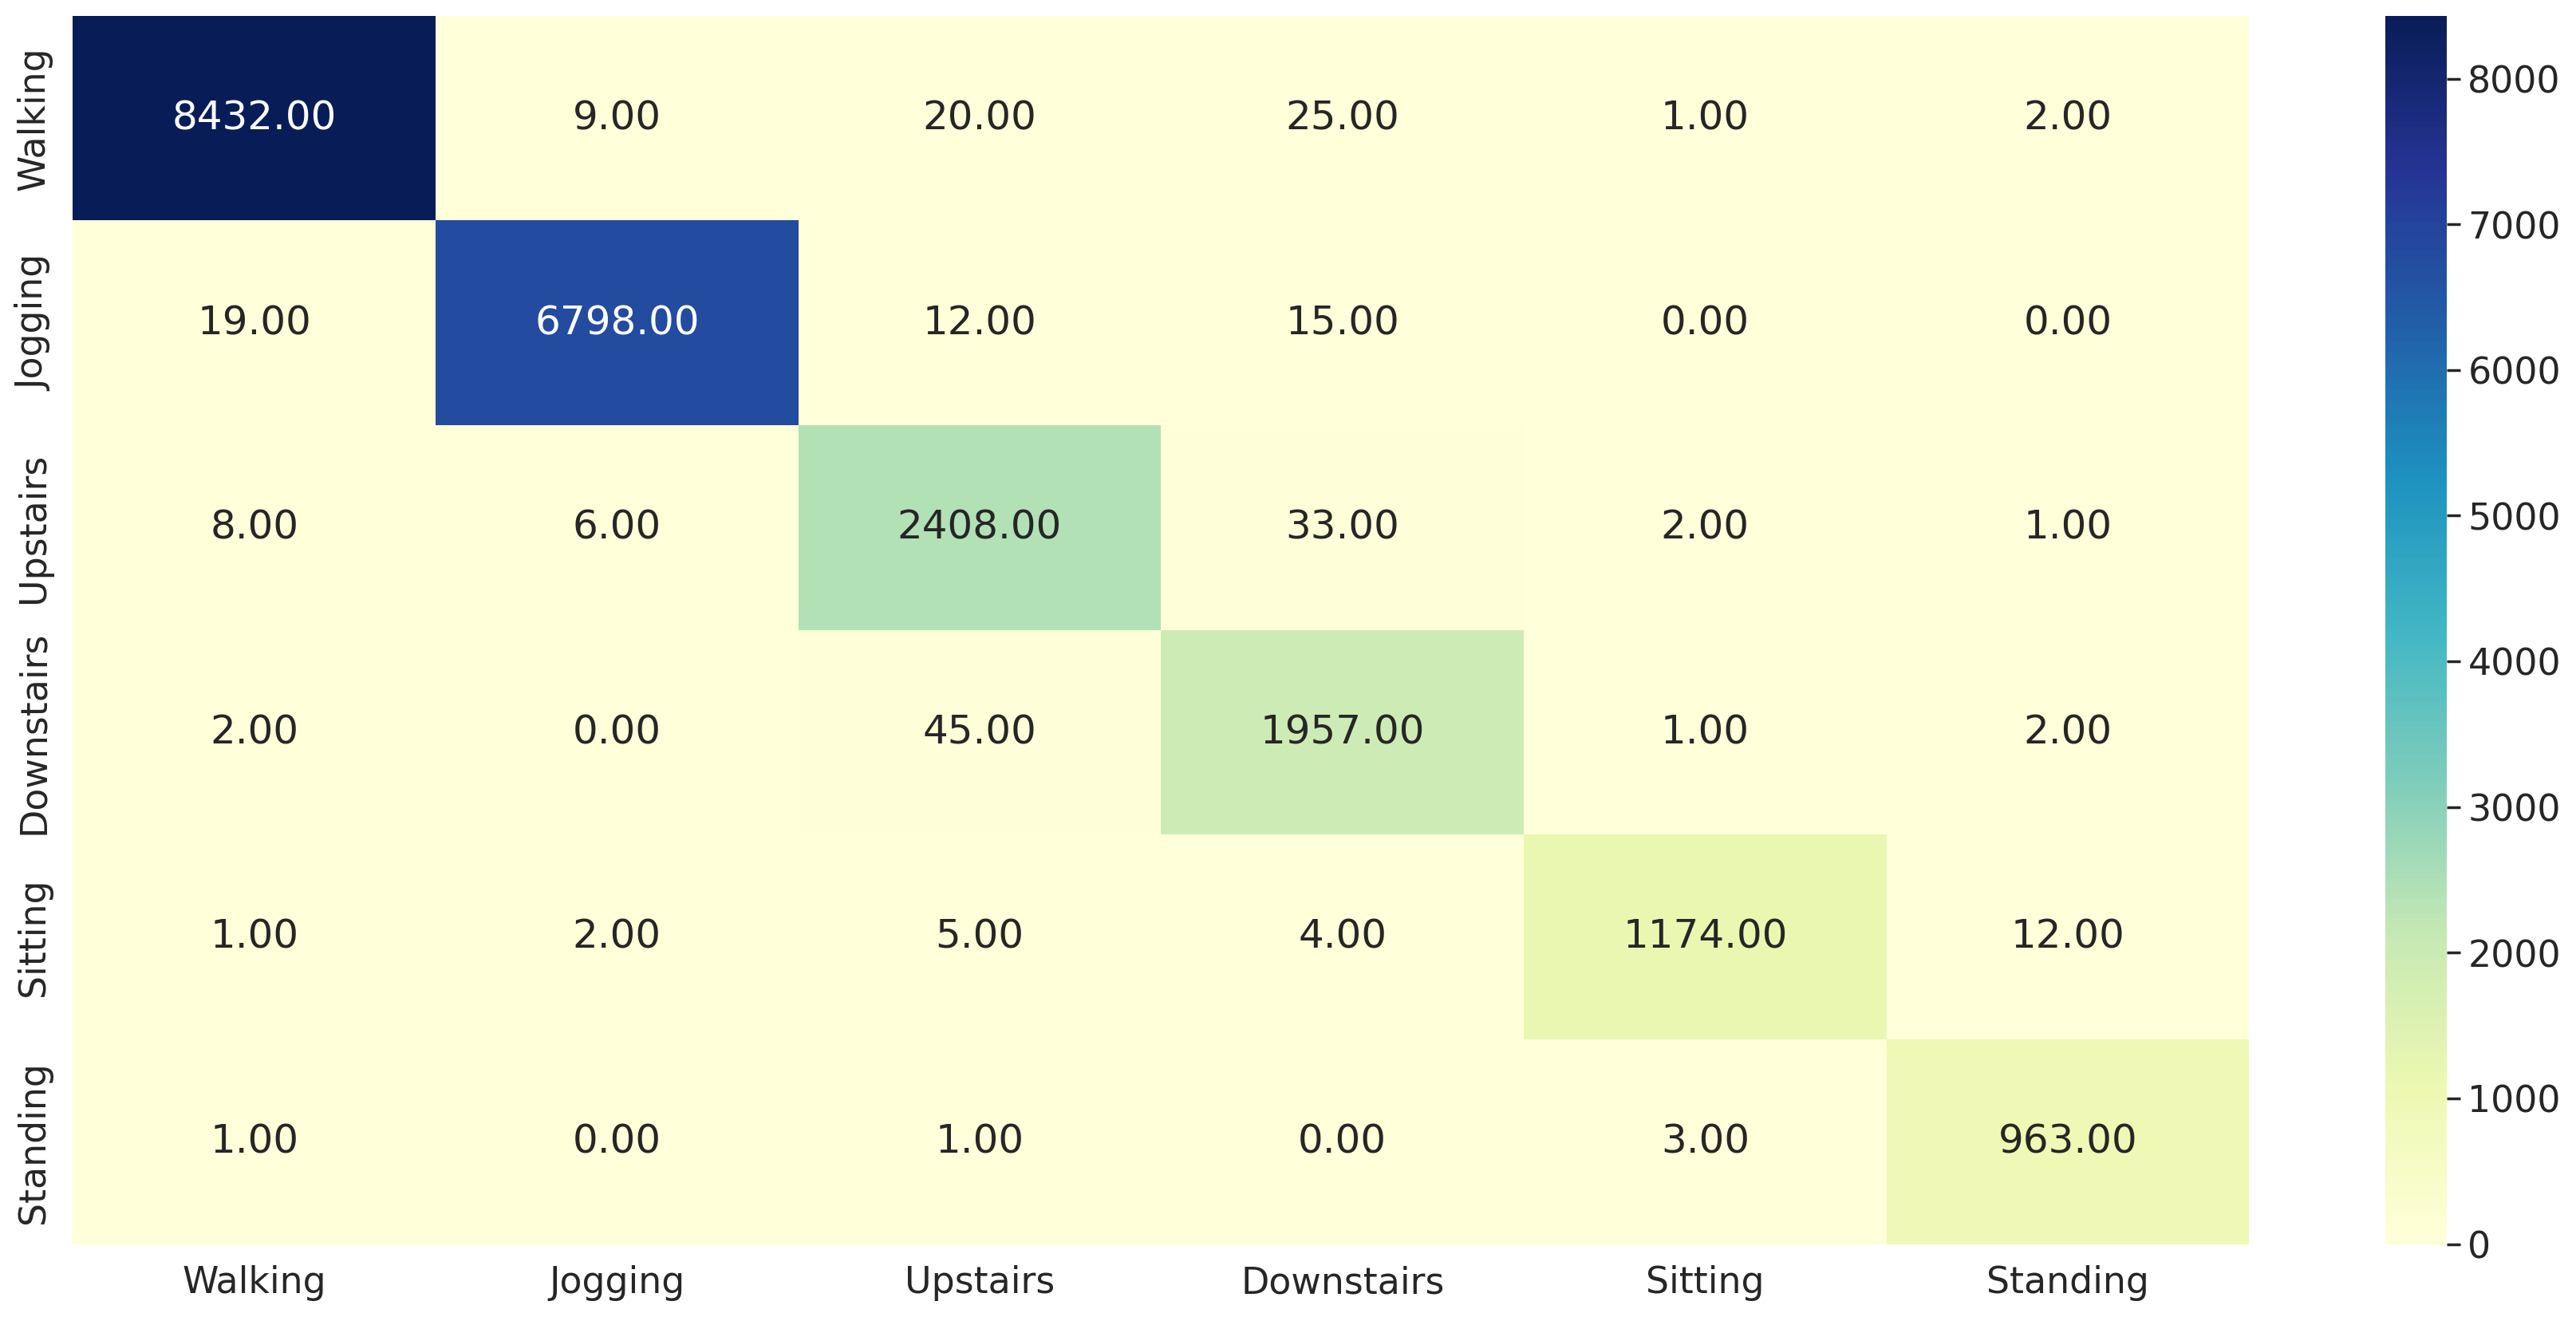

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU4

In [28]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 50, 256)           102144    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 50, 256)           296448    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 50, 256)           296448    
 onal)                                                           
                                                      

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 36s 41ms/step - loss: 0.4878 - accuracy: 0.8294 - val_loss: 0.1803 - val_accuracy: 0.9416
Epoch 2/10
550/550 [==============================] - 20s 36ms/step - loss: 0.1532 - accuracy: 0.9497 - val_loss: 0.0914 - val_accuracy: 0.9702
Epoch 3/10
550/550 [==============================] - 21s 38ms/step - loss: 0.0966 - accuracy: 0.9688 - val_loss: 0.0853 - val_accuracy: 0.9752
Epoch 4/10
550/550 [==============================] - 21s 38ms/step - loss: 0.0682 - accuracy: 0.9777 - val_loss: 0.0567 - val_accuracy: 0.9832
Epoch 5/10
550/550 [==============================] - 20s 36ms/step - loss: 0.0566 - accuracy: 0.9825 - val_loss: 0.0482 - val_accuracy: 0.9859
Epoch 6/10
550/550 [==============================] - 20s 36ms/step - loss: 0.0468 - accuracy: 0.9855 - val_loss: 0.0402 - val_accuracy: 0.9886
Epoch 7/10
550/550 [==============================] - 20s 36ms/step - loss: 0.0386 - accuracy: 0.9879 - val_loss: 0.0376 - val_accuracy:

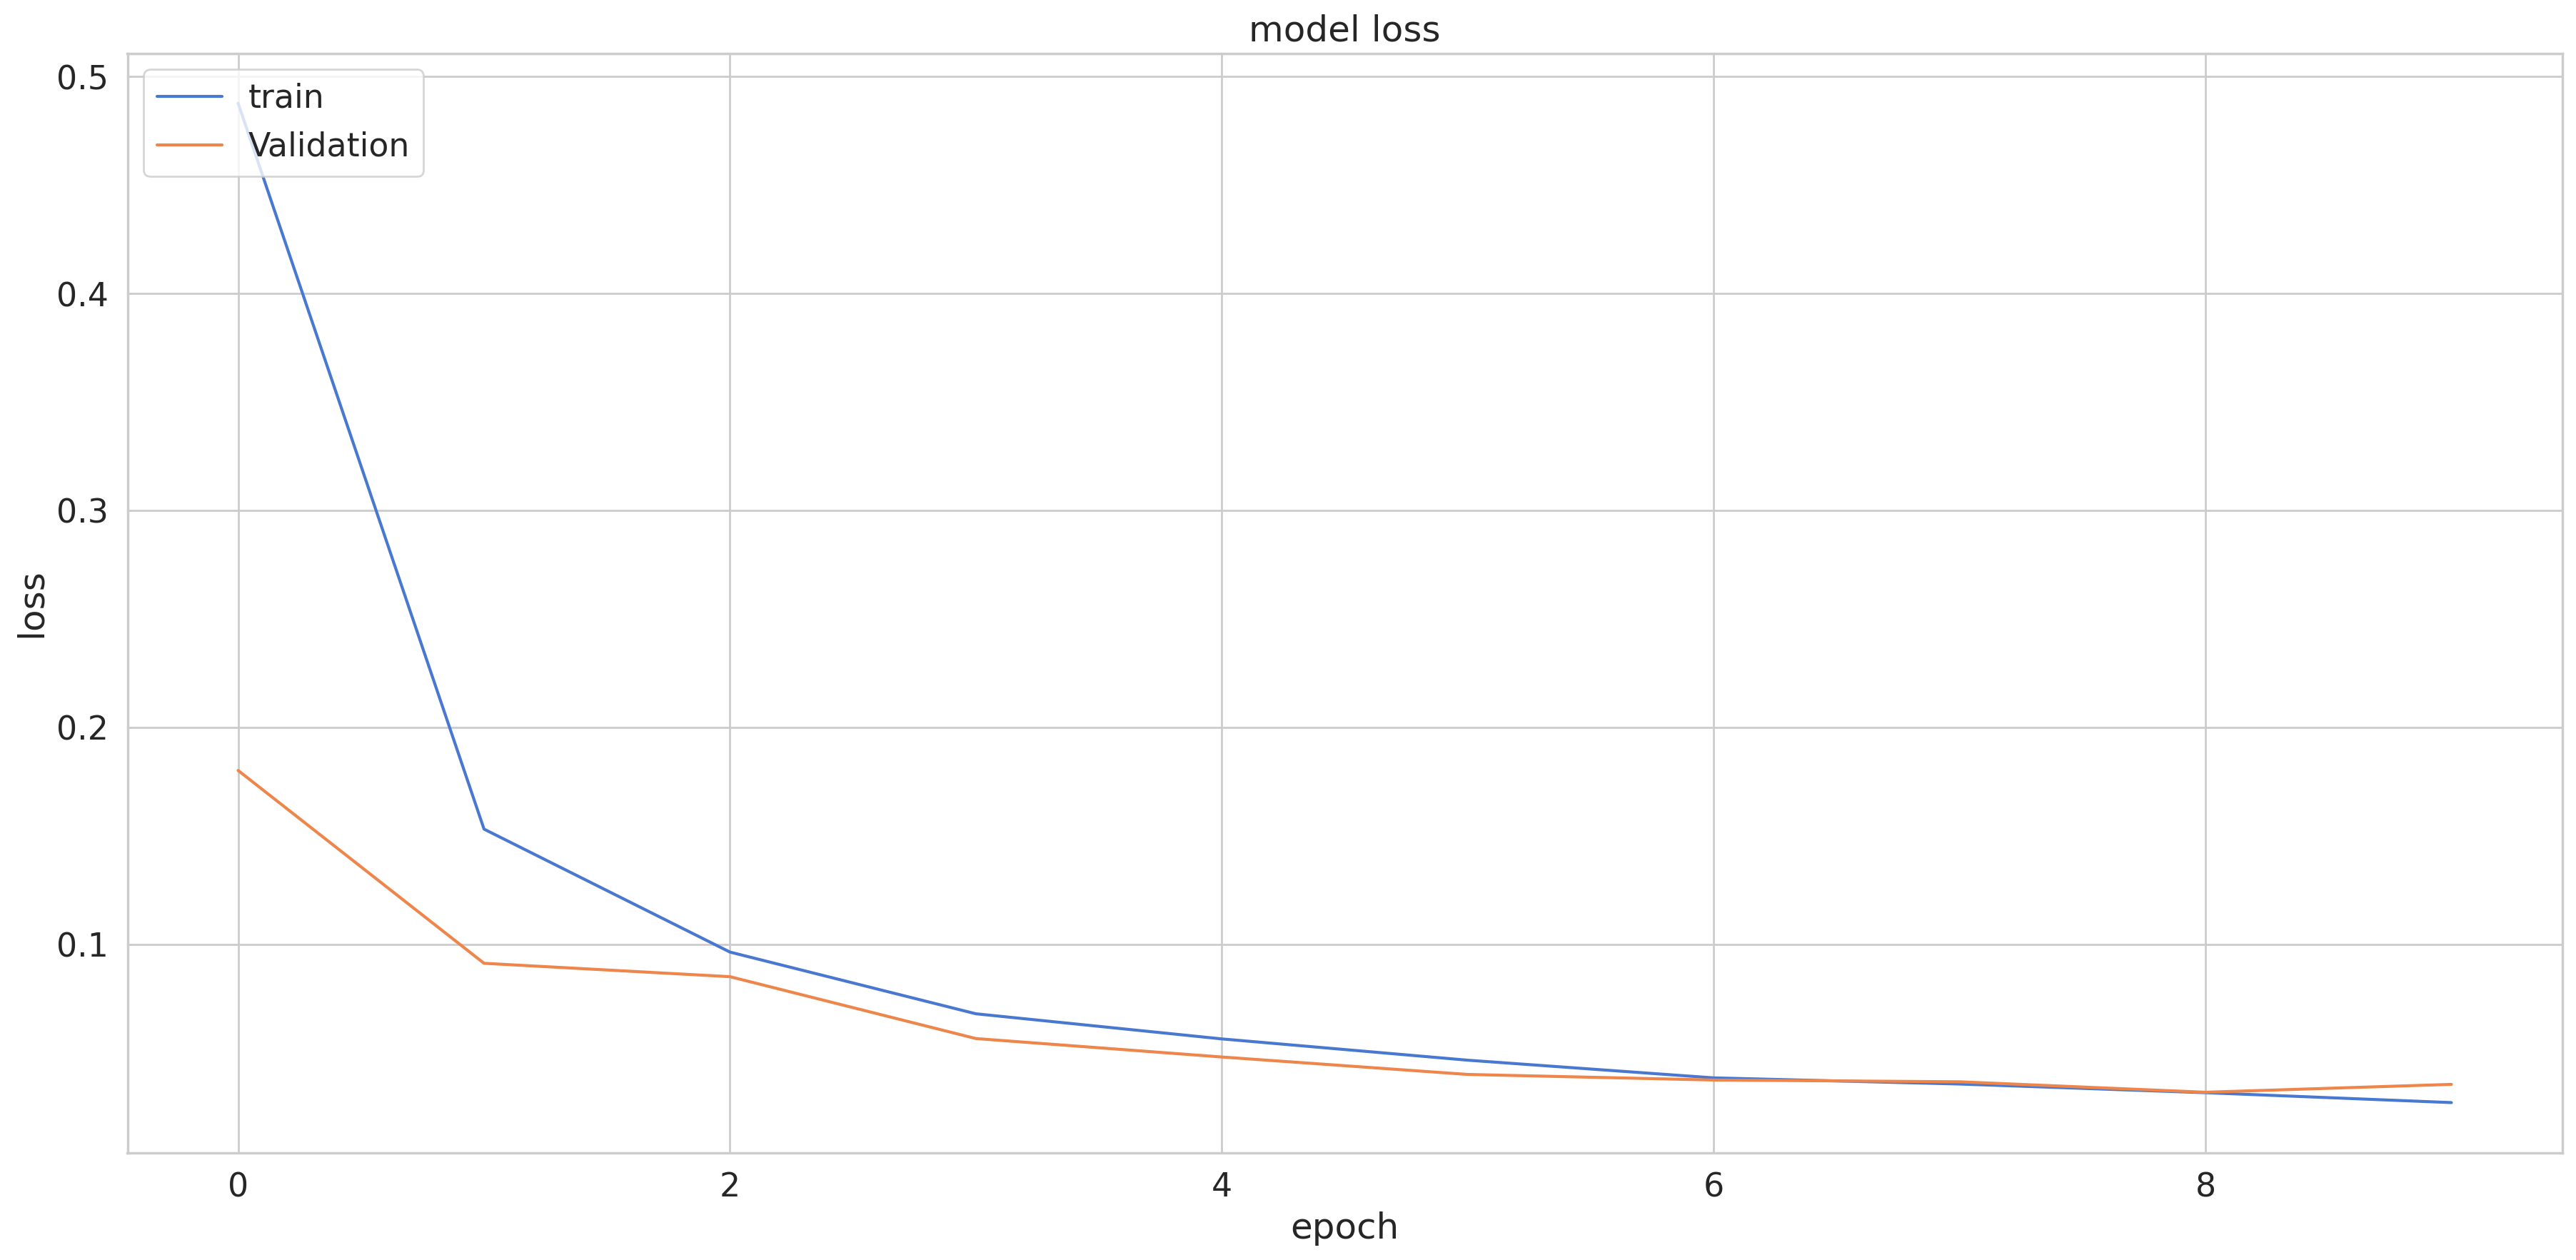

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

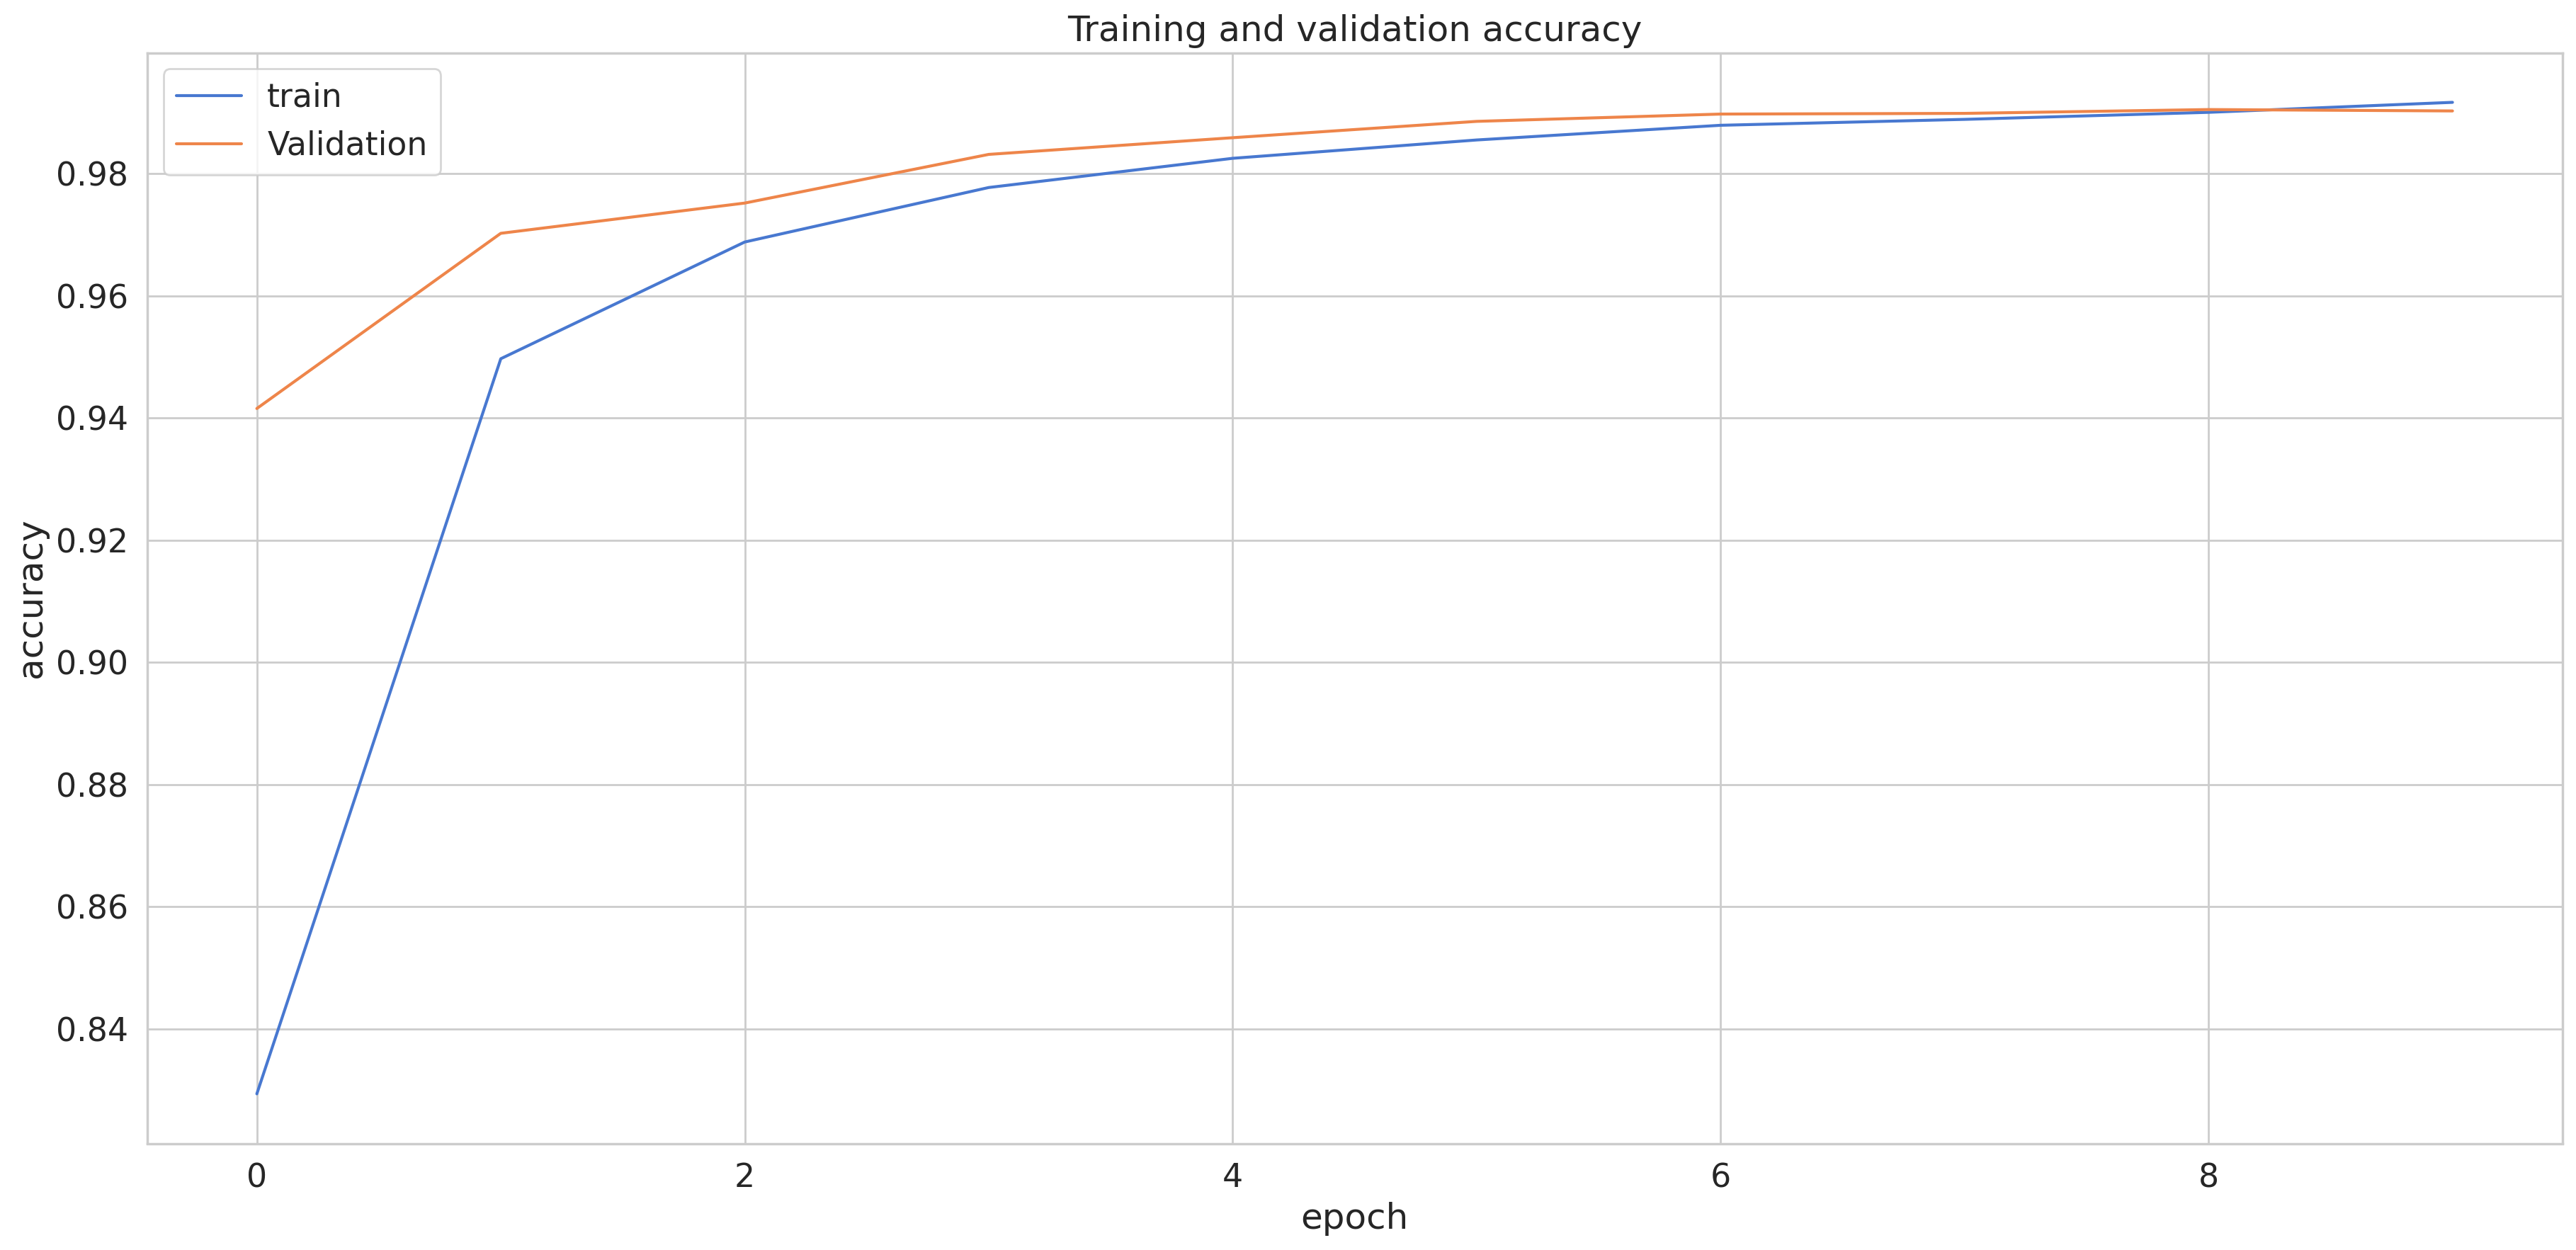

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 10s 10ms/step
f1_score =  0.9890071846020062
0.9889819704971772
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8489
           1       1.00      1.00      1.00      6844
           2       0.96      0.99      0.97      2458
           3       0.97      0.96      0.97      2007
           4       1.00      0.98      0.99      1198
           5       0.98      1.00      0.99       968

    accuracy                           0.99     21964
   macro avg       0.98      0.99      0.98     21964
weighted avg       0.99      0.99      0.99     21964



<Axes: >

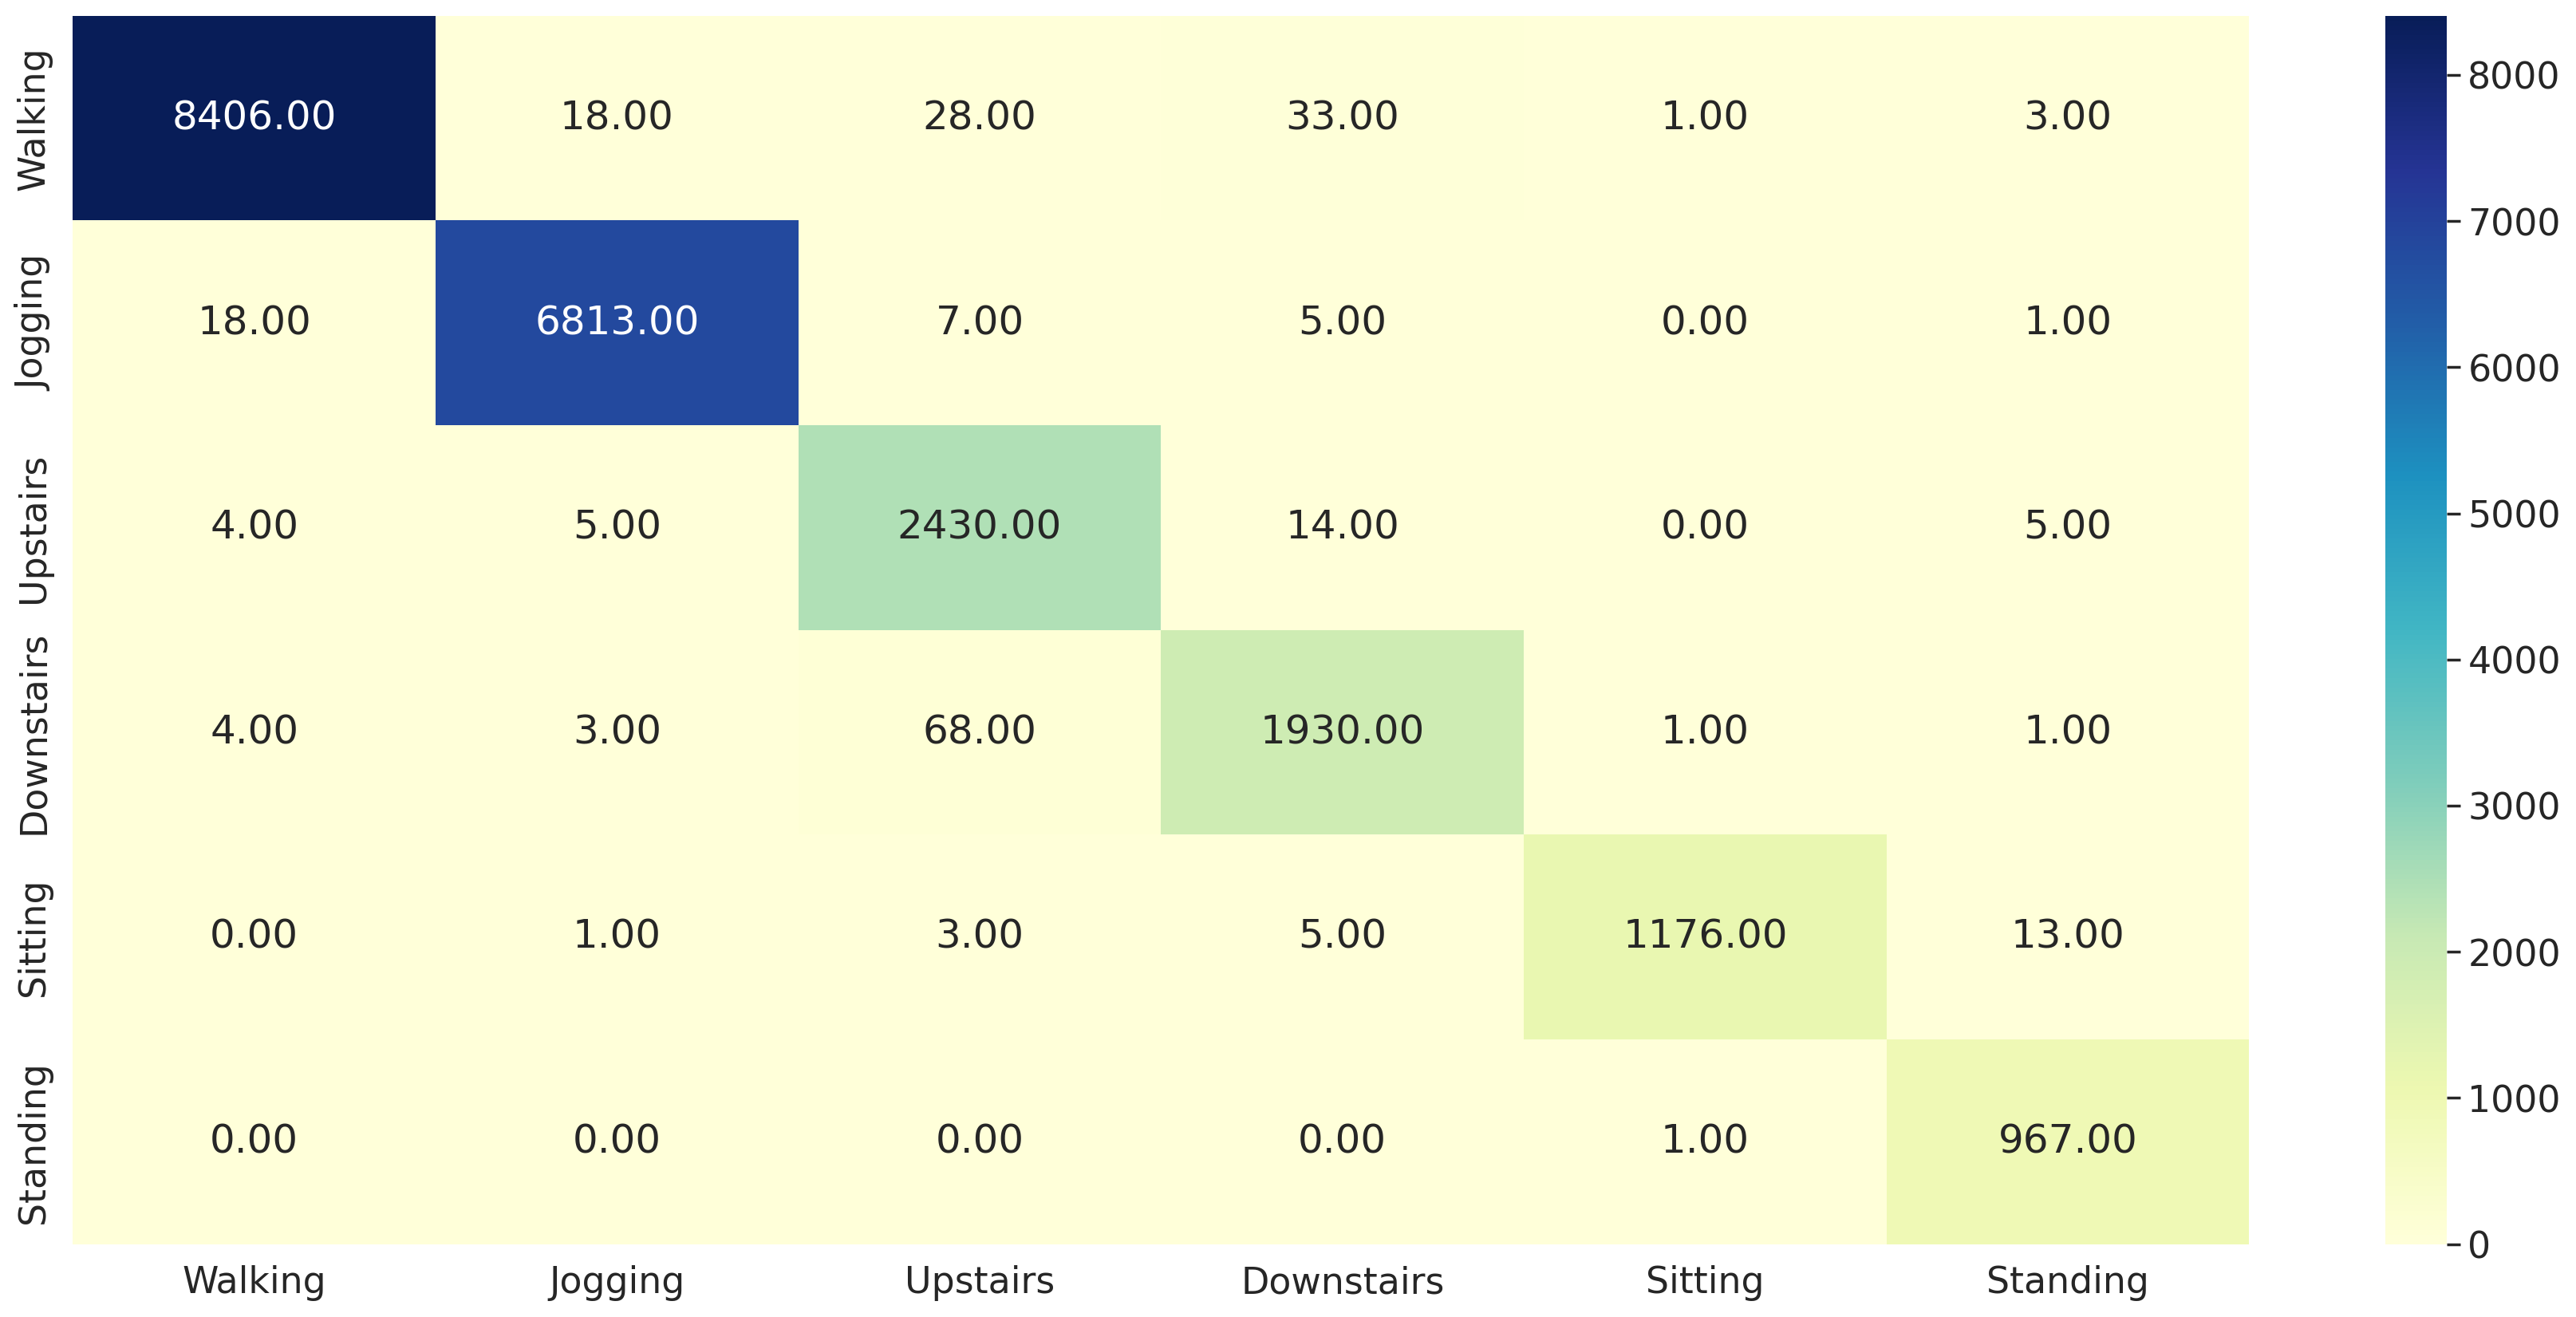

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [33]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 50, 256)           102144    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 50, 256)           296448    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 50, 256)           296448    
 ional)                                                          
                                                      

In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 44s 50ms/step - loss: 0.4783 - accuracy: 0.8301 - val_loss: 0.1849 - val_accuracy: 0.9423
Epoch 2/10
550/550 [==============================] - 25s 45ms/step - loss: 0.1494 - accuracy: 0.9524 - val_loss: 0.0939 - val_accuracy: 0.9721
Epoch 3/10
550/550 [==============================] - 26s 46ms/step - loss: 0.0977 - accuracy: 0.9686 - val_loss: 0.0704 - val_accuracy: 0.9788
Epoch 4/10
550/550 [==============================] - 25s 45ms/step - loss: 0.0712 - accuracy: 0.9778 - val_loss: 0.0674 - val_accuracy: 0.9810
Epoch 5/10
550/550 [==============================] - 25s 46ms/step - loss: 0.0544 - accuracy: 0.9834 - val_loss: 0.0587 - val_accuracy: 0.9829
Epoch 6/10
550/550 [==============================] - 25s 46ms/step - loss: 0.0468 - accuracy: 0.9853 - val_loss: 0.0457 - val_accuracy: 0.9861
Epoch 7/10
550/550 [==============================] - 24s 45ms/step - loss: 0.0434 - accuracy: 0.9864 - val_loss: 0.0385 - val_accuracy:

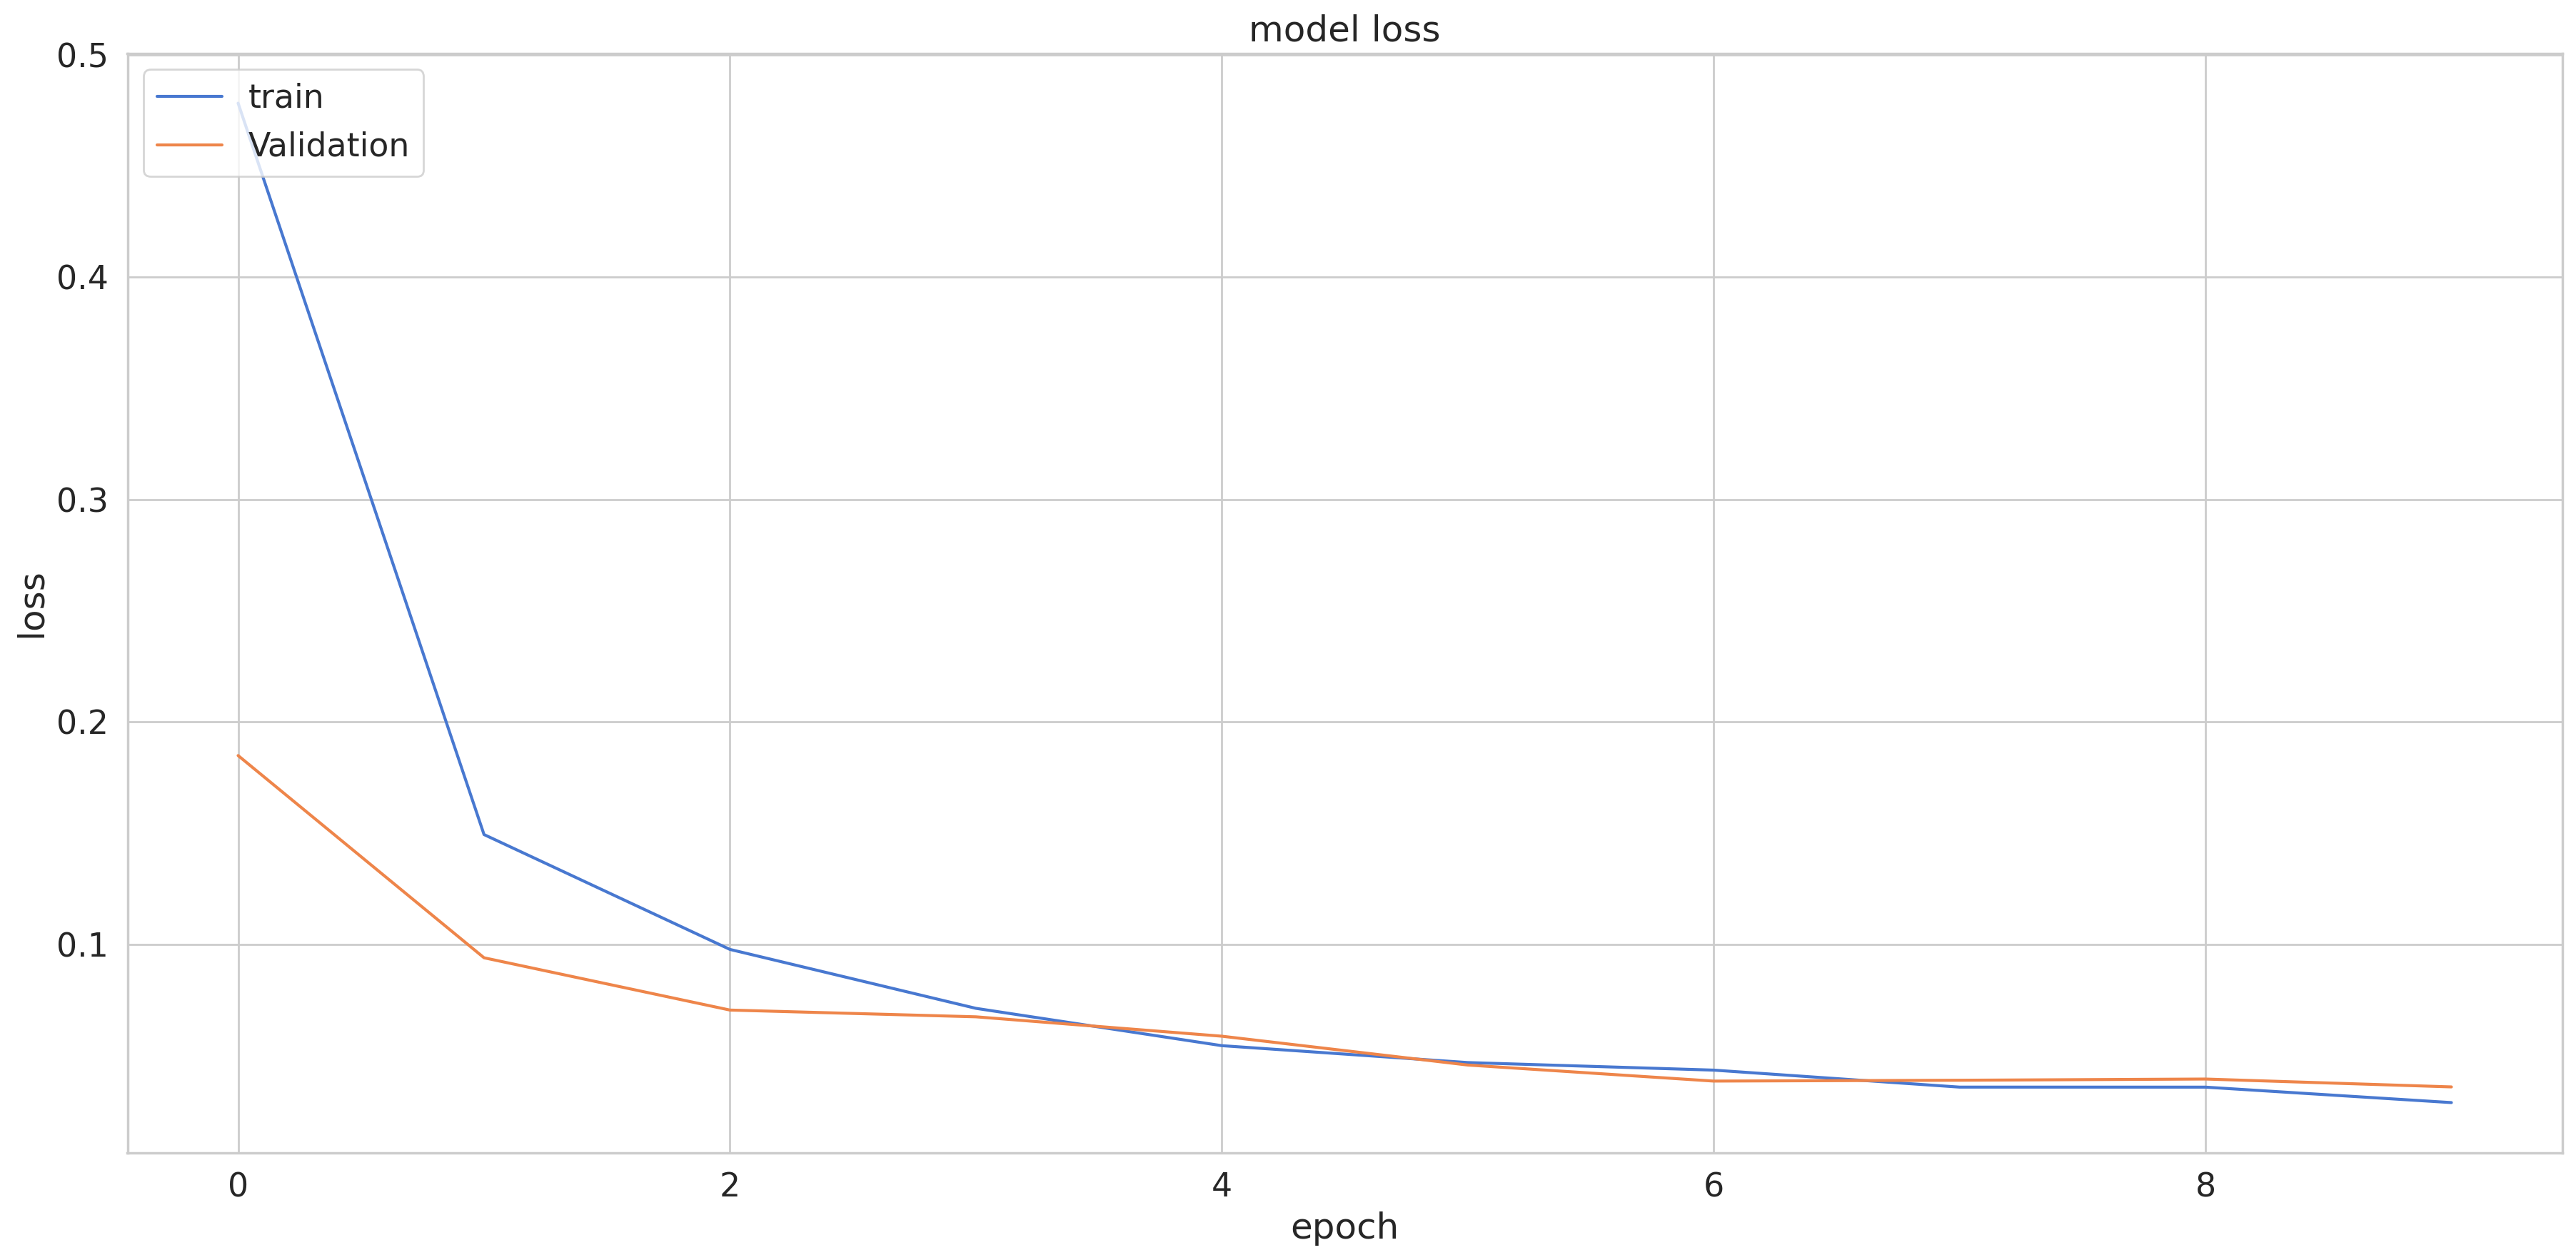

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

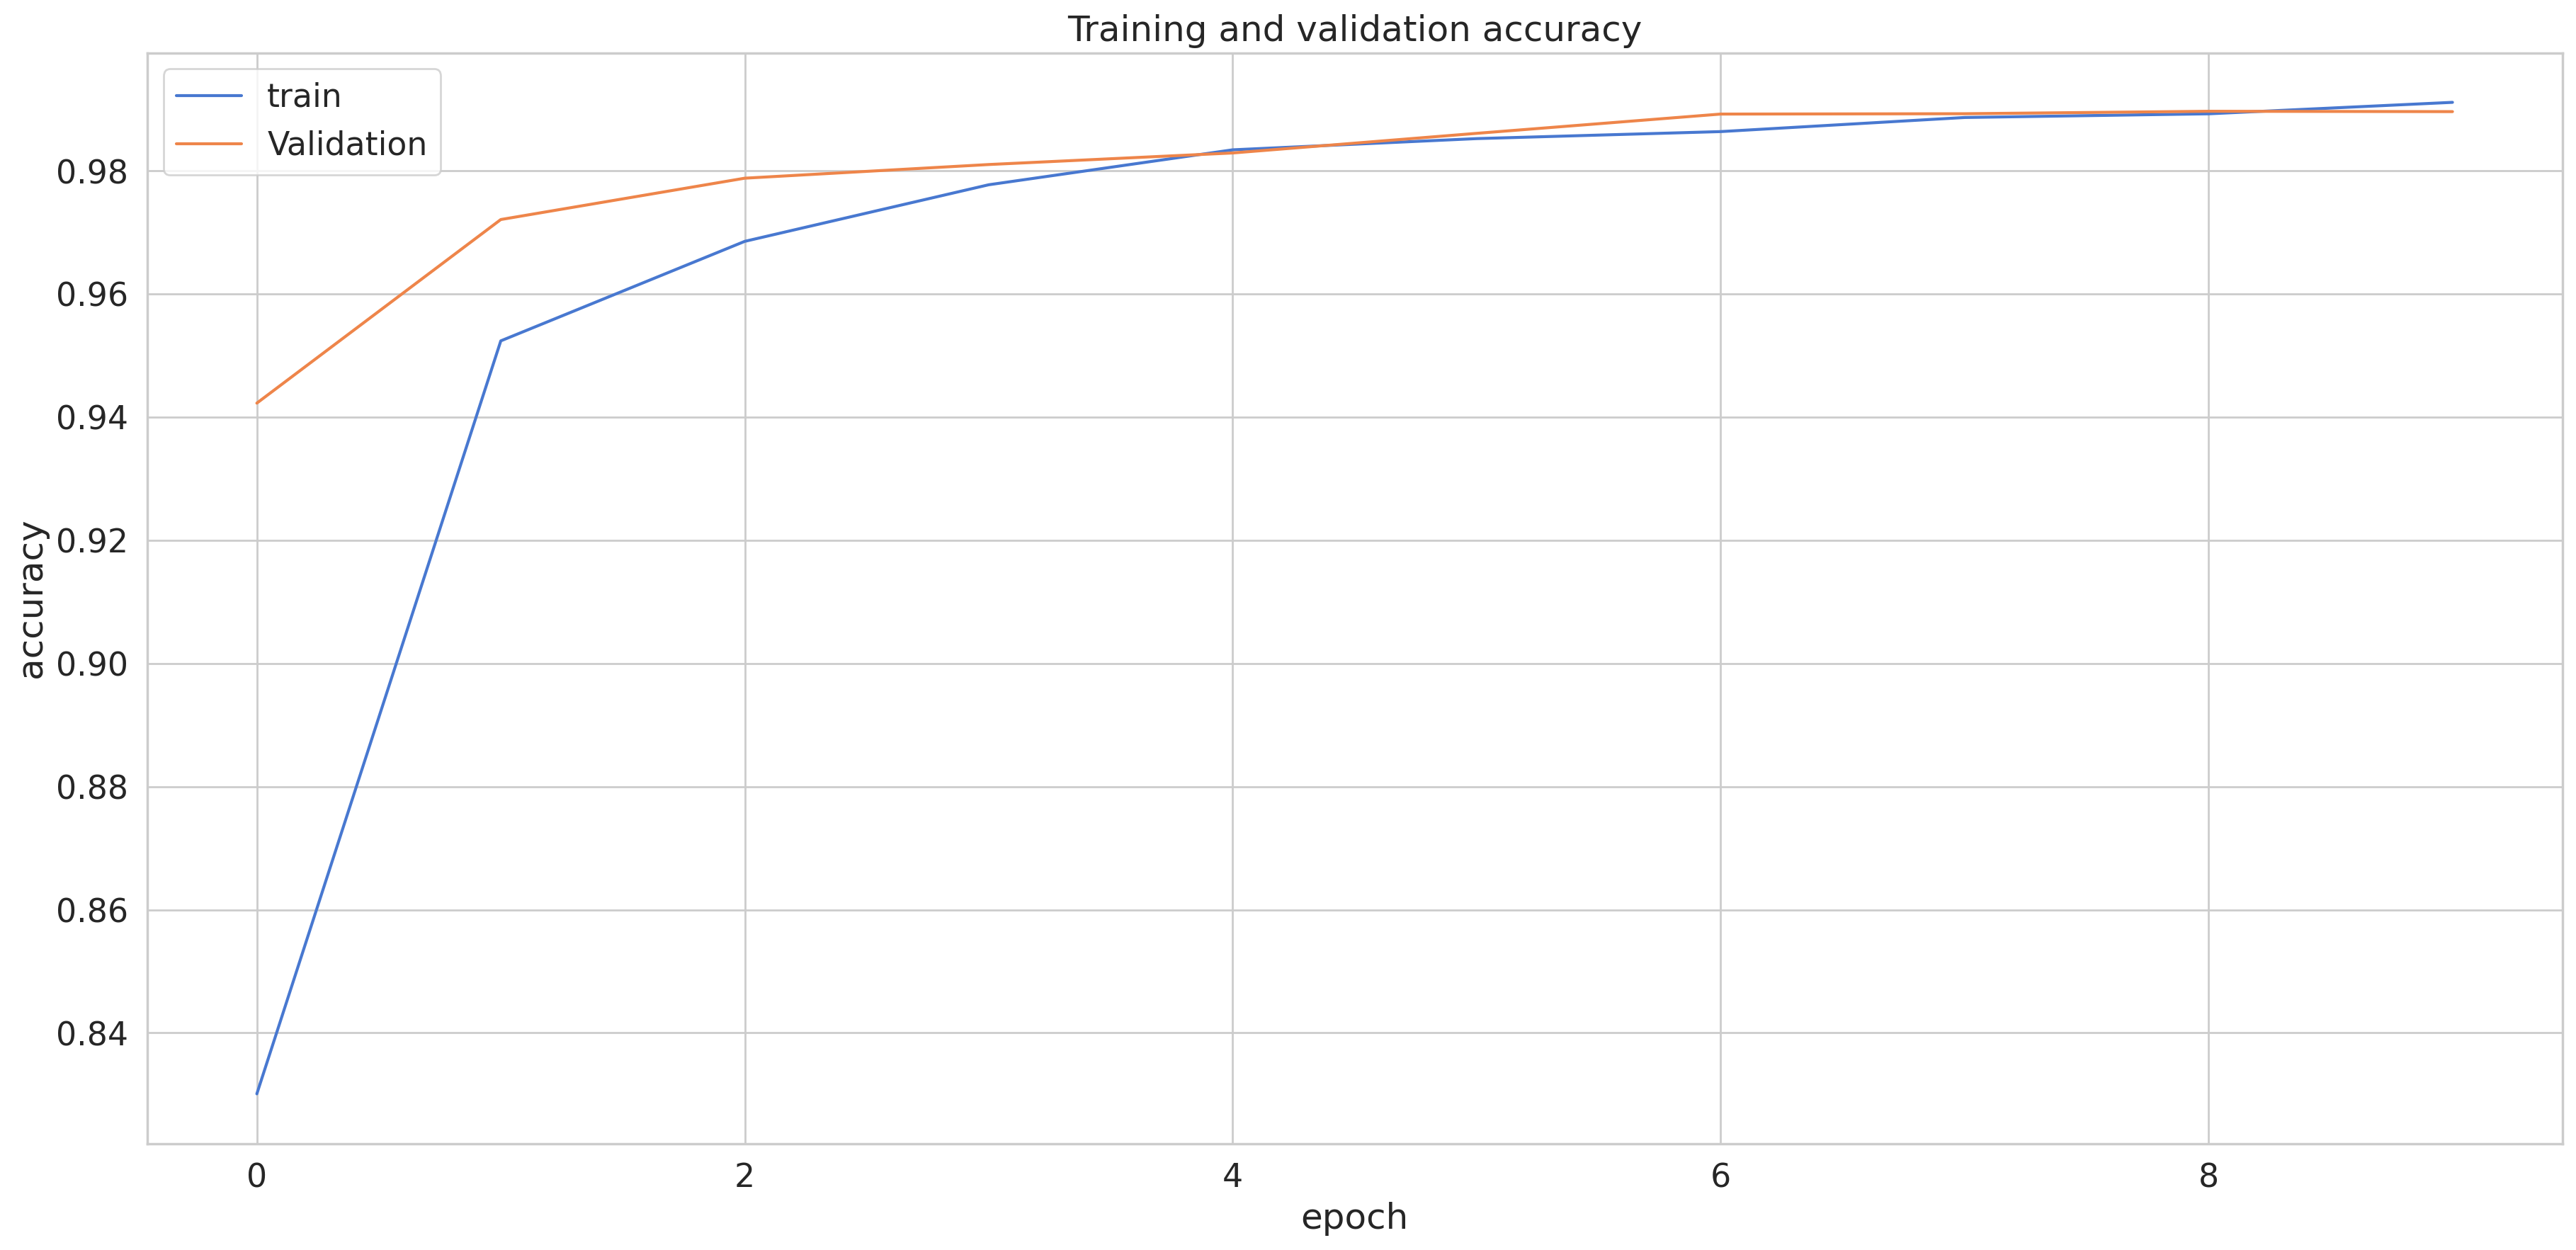

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 11s 12ms/step
f1_score =  0.9886336911729808
0.9886177381169186
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8489
           1       0.99      1.00      0.99      6844
           2       0.96      0.98      0.97      2458
           3       0.98      0.96      0.97      2007
           4       0.99      0.99      0.99      1198
           5       0.98      0.99      0.99       968

    accuracy                           0.99     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.99      0.99      0.99     21964



<Axes: >

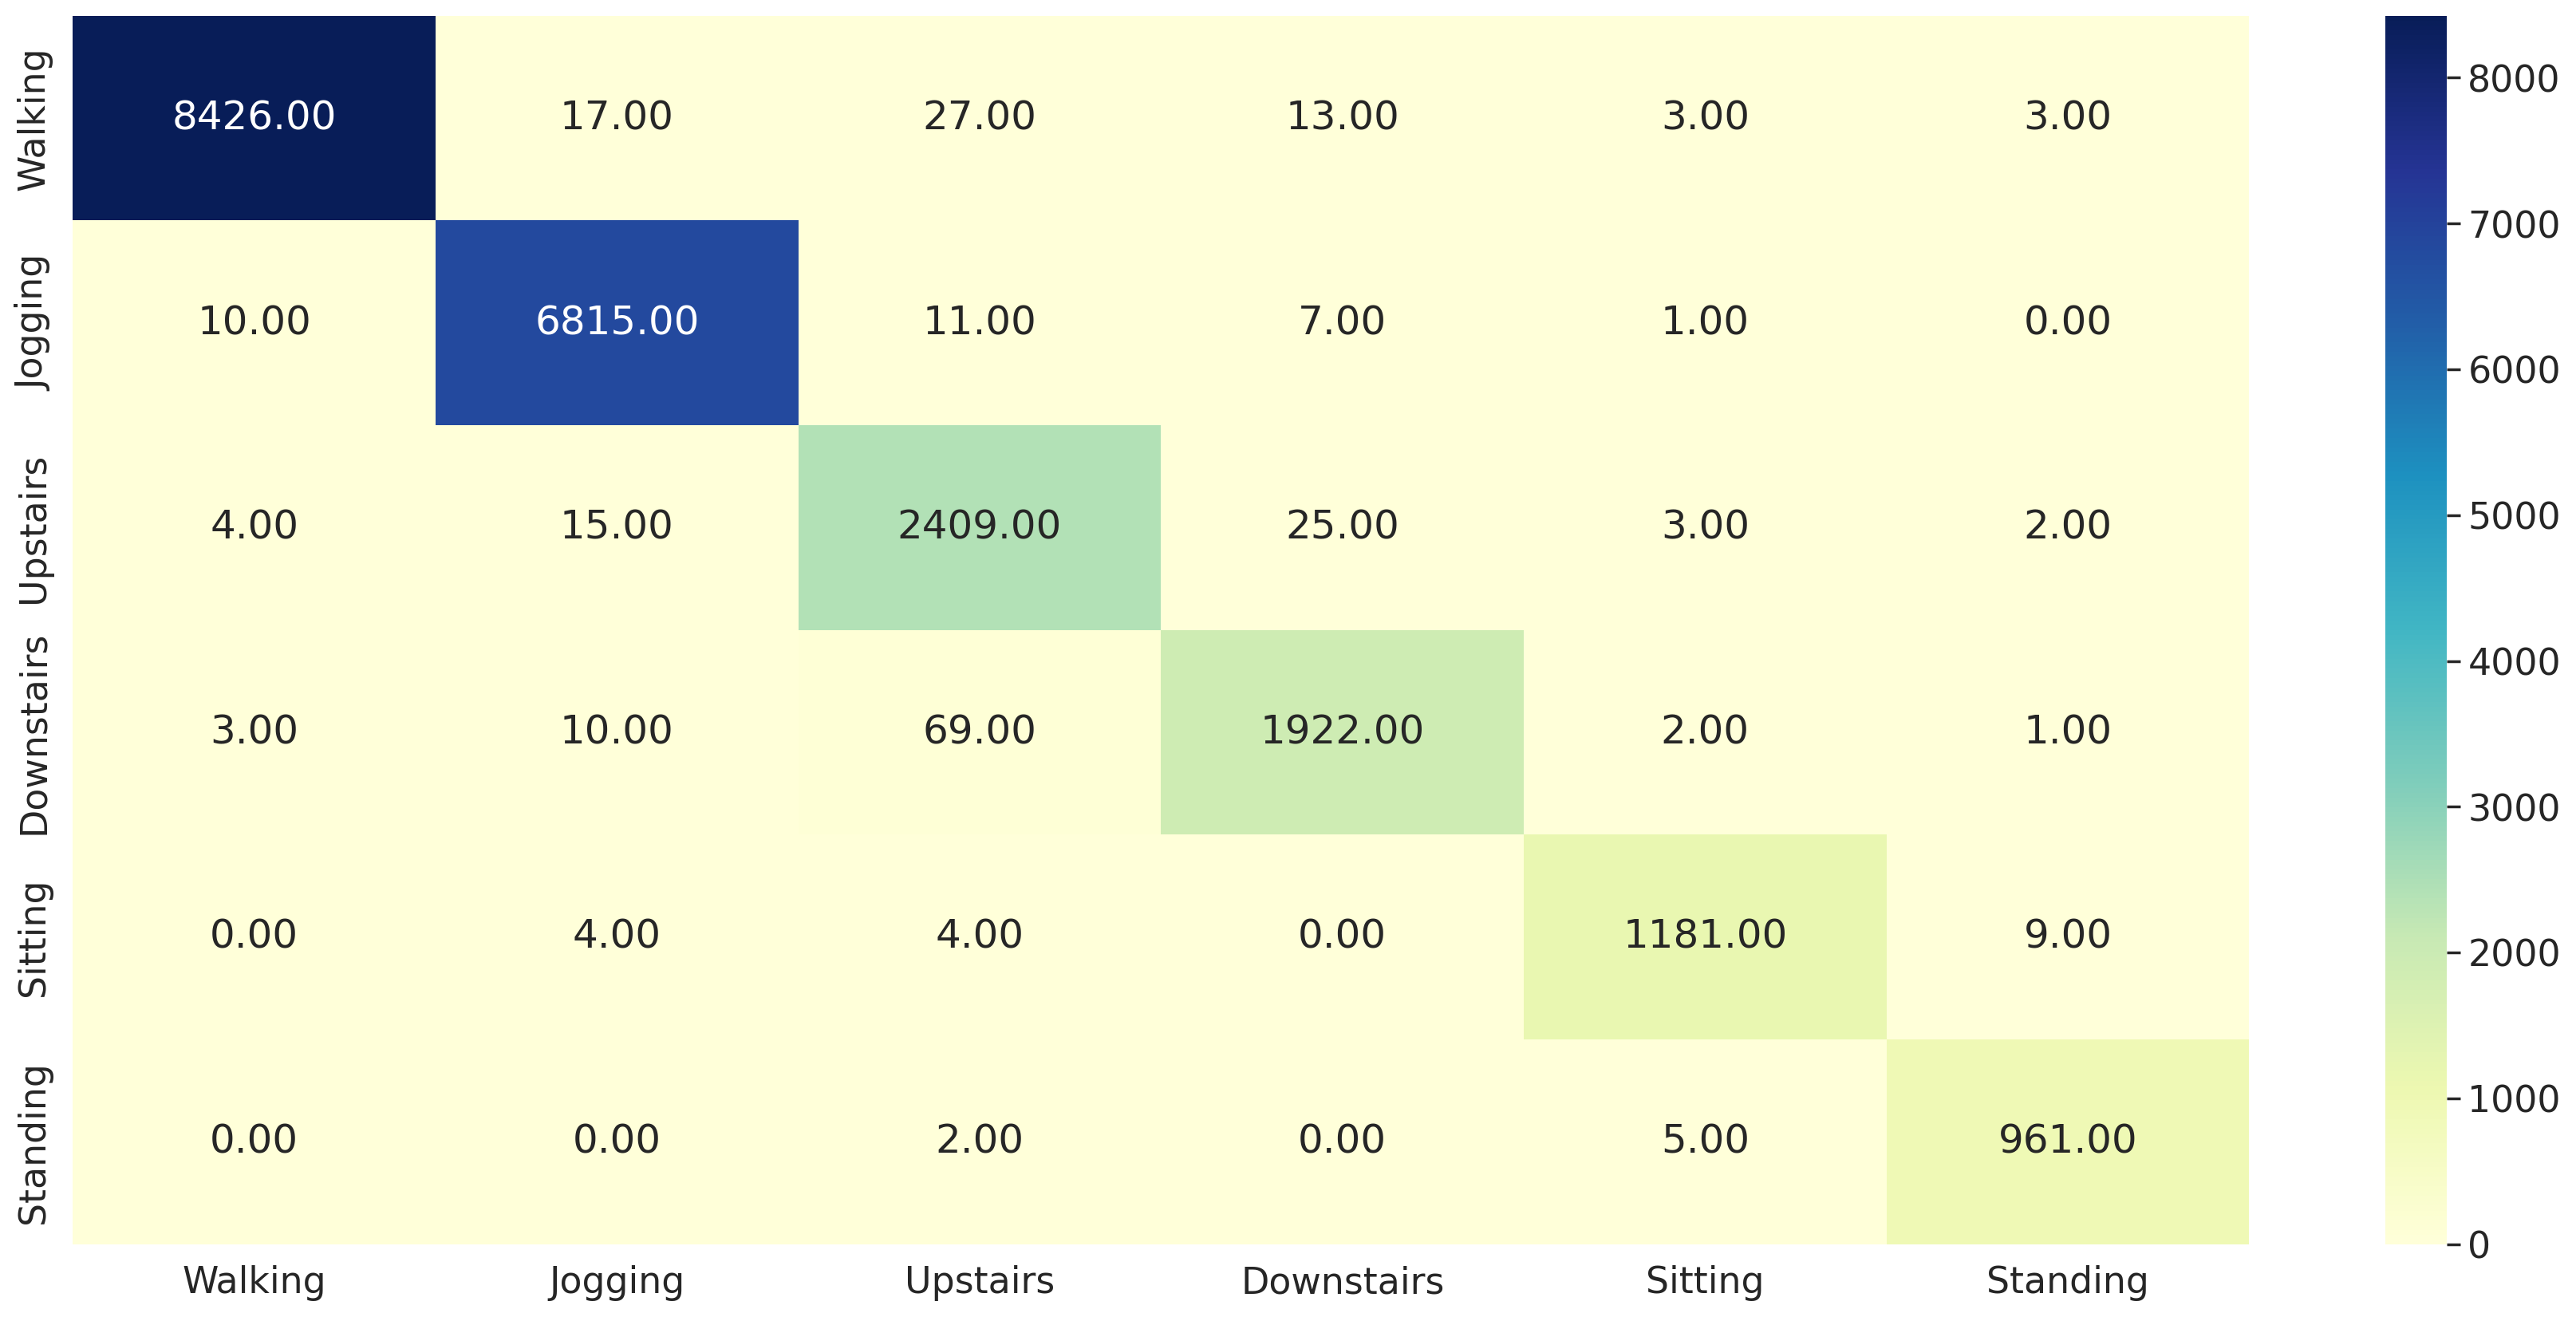

In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')